In [749]:
import numpy as np
import math
import os
from tqdm import tqdm

# import lib for img processing
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import torchvision.transforms.functional as functional

# import lib for data processing
from torch.utils.data import DataLoader
from torchvision import datasets


#　in this tutorial, i implement pytorch
import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [750]:
n_epochs = 300 #epochs
batch_size = 50   #batch size recommend that more than 32
g_lr_rate = 0.0007   #learning rate
d_lr_rate = 0.0002  #learning rate
beta1 = 0.37    #learning rate beta1
beta2 = 0.777    #beta2
ext_size = 480   #extend
tmp_size = 420   #image tmp crop size
img_size = 64   #image size
channels = 3    #RGB
img_shape = (channels, img_size, img_size) # gray scale (channels,img_size,img_size)
img_pixel = int(np.prod(img_shape)) # total pixel is 1*img_size*img_size
z_dim = 100     #z_dim is latent_dim
interval = 70  # How often to sample

# dirpath='real_only'
# dirpath='anime_only'
# dirpath='real+anime'
dirpath='real+anime+me'


gpath = f"{dirpath}_generator.pth"
dpath = f"{dirpath}_discriminator.pth"

In [751]:
# class CenterCropAndResize(object):
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, image):
#         width, height = image.size
#         short_side = min(width, height)

#         image= functional.center_crop(image, short_side)
#         image= functional.resize(image,self.output_size)

#         return image

In [752]:
# 定義圖像轉換
# transform = transforms.Compose([
#     transforms.CenterCrop((tmp_size, tmp_size)),      # 切大小為 tmp_size*tmp_size
#     transforms.Resize((img_size, img_size)),        # 縮放img_size*img_size
#     transforms.ToTensor(),            # 轉換為 tensor
#     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])  # 正規化圖像
# ])
transform = transforms.Compose([
    # CenterCropAndResize(64),  # 中心裁剪到正方形，然後縮放到 720x720
    transforms.Resize((ext_size, ext_size)),        # 縮放img_size*img_size
#     transforms.CenterCrop((tmp_size, tmp_size)),      # 切大小為 tmp_size*tmp_size
    transforms.Resize((img_size, img_size)),        # 縮放img_size*img_size
    transforms.ToTensor(),  # 轉換為 tensor
    transforms.Normalize([0.5], [0.5])  # 正規化圖像
])

# 創建 ImageFolder 數據集實例
dataset = ImageFolder(root=f'data/{dirpath}', transform=transform)
# 使用 DataLoader 加載數據集
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [753]:
# creat a Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)
    

In [754]:
# create a generator
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


In [755]:
adversarial_loss = torch.nn.BCELoss()

# at first we need to get our gpu!
if torch.cuda.is_available():
    device =torch.device("cuda:0")
else:
    device =torch.device('cpu')

# call the generator and discriminator
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=g_lr_rate, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=d_lr_rate, betas=(beta1, beta2))

os.makedirs(f"./result_images/{dirpath}", exist_ok=True)

In [756]:
# ------------------
# Training Start
# ------------------
G_losses=[]
G_losses_batch=[]
D_losses=[]
trainD=True
# # 檢查路徑是否存在
if os.path.exists(gpath):
    generator.load_state_dict(torch.load(gpath))
if os.path.exists(dpath):
    discriminator.load_state_dict(torch.load(dpath))
print("FINISHING LOADING PTH")


for epoch in range(n_epochs):
    for batch_id, (img, _) in enumerate(tqdm(dataloader)):
        # throw our img into gpu
        real_imgs = img.to(device)
        # create label to caculate BCE
        _valid = torch.ones(size=(real_imgs.shape[0],), requires_grad=False).to(device) # (batch_size, 1) [1, 1, 1,...]
        _fake = torch.zeros(size=(real_imgs.shape[0],), requires_grad=False).to(device) # (batch_size, 0) [0, 0, 0,...]
    
    
    
        if trainD:
            # --------------------
            # Train Discriminator
            # --------------------
            # Discriminator: max log(D(x)) + log(1 - D(G(z)))
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), _valid)
#             real_loss.backward(retain_graph=True)
            # Sample noise
            zz = torch.randn(real_imgs.shape[0], z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
            # generate images!
            Dgen_imgs = generator(zz)
            fake_loss = adversarial_loss(discriminator(Dgen_imgs.detach()), _fake)
            d_loss = (real_loss + fake_loss)/2
            d_loss.backward()
            
            optimizer_D.step()
            D_losses.append(d_loss.item())
            
            if d_loss.item()<0.5:
                trainD=False
    
    
        # -----------------
        # Train Generator
        # -----------------
        # Reset 
        optimizer_G.zero_grad()
        # Sample noise
        z = torch.randn(real_imgs.shape[0], z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
        # generate images!
        gen_imgs = generator(z)
        # Generator :min log(1 - D(G(z))) <-> max log(D(G(z))
        g_loss = adversarial_loss(discriminator(gen_imgs), _valid)
        g_loss.backward()
        optimizer_G.step()
#         G_losses_batch.append(g_loss.item())
#         if len(G_losses_batch) == len(dataloader):
#             # 计算G_losses_batch的平均值
#             avg_g_loss = sum(G_losses_batch) / len(G_losses_batch)
#             G_losses.append(avg_g_loss)
#             G_losses_batch.clear()
        
        G_losses.append(g_loss.item())
        
        if(g_loss.item()<0.37) or g_loss.item()<d_loss.item():
            trainD=True
            
    
        print(
          "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
          % (epoch, n_epochs, batch_id, len(dataloader), d_loss.item(), g_loss.item())
        )
    
        batches_done = epoch * len(dataloader) + batch_id
        if batches_done % interval == 0:
            save_image(gen_imgs.data[:25], f"result_images/{dirpath}/%d.png" % batches_done, nrow=5, normalize=True)

            
# save
print("SAVING PTH")
torch.save(generator.state_dict(), gpath)
torch.save(discriminator.state_dict(), dpath)         

FINISHING LOADING PTH


 17%|█▋        | 1/6 [00:00<00:01,  3.05it/s]

[Epoch 0/300] [Batch 0/6] [D loss: 0.489354] [G loss: 2.114518]


 33%|███▎      | 2/6 [00:00<00:01,  3.58it/s]

[Epoch 0/300] [Batch 1/6] [D loss: 0.489354] [G loss: 2.022512]


 50%|█████     | 3/6 [00:00<00:00,  3.89it/s]

[Epoch 0/300] [Batch 2/6] [D loss: 0.489354] [G loss: 2.033106]


 67%|██████▋   | 4/6 [00:01<00:00,  4.06it/s]

[Epoch 0/300] [Batch 3/6] [D loss: 0.489354] [G loss: 2.164847]


 83%|████████▎ | 5/6 [00:01<00:00,  4.08it/s]

[Epoch 0/300] [Batch 4/6] [D loss: 0.489354] [G loss: 2.226471]


100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


[Epoch 0/300] [Batch 5/6] [D loss: 0.489354] [G loss: 2.398771]


 17%|█▋        | 1/6 [00:00<00:01,  4.79it/s]

[Epoch 1/300] [Batch 0/6] [D loss: 0.489354] [G loss: 2.155470]


 33%|███▎      | 2/6 [00:00<00:00,  4.10it/s]

[Epoch 1/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.915108]


 50%|█████     | 3/6 [00:00<00:00,  3.82it/s]

[Epoch 1/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.939001]


 67%|██████▋   | 4/6 [00:01<00:00,  3.54it/s]

[Epoch 1/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.942262]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 1/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.986957]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 1/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.904758]


 17%|█▋        | 1/6 [00:00<00:01,  3.78it/s]

[Epoch 2/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.947082]


 33%|███▎      | 2/6 [00:00<00:01,  3.85it/s]

[Epoch 2/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.755832]


 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

[Epoch 2/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.997120]


 67%|██████▋   | 4/6 [00:01<00:00,  3.73it/s]

[Epoch 2/300] [Batch 3/6] [D loss: 0.489354] [G loss: 2.210643]


 83%|████████▎ | 5/6 [00:01<00:00,  3.70it/s]

[Epoch 2/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.816975]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 2/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.939143]


 17%|█▋        | 1/6 [00:00<00:01,  3.48it/s]

[Epoch 3/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.928116]


 33%|███▎      | 2/6 [00:00<00:01,  3.67it/s]

[Epoch 3/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.906176]


 50%|█████     | 3/6 [00:00<00:00,  3.67it/s]

[Epoch 3/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.925225]


 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

[Epoch 3/300] [Batch 3/6] [D loss: 0.489354] [G loss: 2.008729]


 83%|████████▎ | 5/6 [00:01<00:00,  3.64it/s]

[Epoch 3/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.870366]


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


[Epoch 3/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.718912]


 17%|█▋        | 1/6 [00:00<00:01,  3.77it/s]

[Epoch 4/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.784379]


 33%|███▎      | 2/6 [00:00<00:01,  3.80it/s]

[Epoch 4/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.902952]


 50%|█████     | 3/6 [00:00<00:00,  3.72it/s]

[Epoch 4/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.905455]


 67%|██████▋   | 4/6 [00:01<00:00,  3.49it/s]

[Epoch 4/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.833405]


 83%|████████▎ | 5/6 [00:01<00:00,  3.52it/s]

[Epoch 4/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.867246]


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


[Epoch 4/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.832044]


 17%|█▋        | 1/6 [00:00<00:01,  3.64it/s]

[Epoch 5/300] [Batch 0/6] [D loss: 0.489354] [G loss: 2.124821]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 5/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.745309]


 50%|█████     | 3/6 [00:00<00:00,  3.69it/s]

[Epoch 5/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.740843]


 67%|██████▋   | 4/6 [00:01<00:00,  3.54it/s]

[Epoch 5/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.906123]


 83%|████████▎ | 5/6 [00:01<00:00,  3.56it/s]

[Epoch 5/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.680038]


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


[Epoch 5/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.871548]


 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

[Epoch 6/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.762663]


 33%|███▎      | 2/6 [00:00<00:01,  3.51it/s]

[Epoch 6/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.781958]


 50%|█████     | 3/6 [00:00<00:00,  3.48it/s]

[Epoch 6/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.801746]


 67%|██████▋   | 4/6 [00:01<00:00,  3.54it/s]

[Epoch 6/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.929719]


 83%|████████▎ | 5/6 [00:01<00:00,  3.53it/s]

[Epoch 6/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.818286]


100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


[Epoch 6/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.867905]


 17%|█▋        | 1/6 [00:00<00:01,  3.89it/s]

[Epoch 7/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.777544]


 33%|███▎      | 2/6 [00:00<00:01,  3.75it/s]

[Epoch 7/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.873941]


 50%|█████     | 3/6 [00:00<00:00,  3.52it/s]

[Epoch 7/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.699578]


 67%|██████▋   | 4/6 [00:01<00:00,  3.35it/s]

[Epoch 7/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.910560]


 83%|████████▎ | 5/6 [00:01<00:00,  3.55it/s]

[Epoch 7/300] [Batch 4/6] [D loss: 0.489354] [G loss: 2.019112]


100%|██████████| 6/6 [00:01<00:00,  3.52it/s]


[Epoch 7/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.753196]


 17%|█▋        | 1/6 [00:00<00:01,  3.79it/s]

[Epoch 8/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.800188]


 33%|███▎      | 2/6 [00:00<00:01,  2.92it/s]

[Epoch 8/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.546617]


 50%|█████     | 3/6 [00:01<00:01,  2.54it/s]

[Epoch 8/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.853231]


 67%|██████▋   | 4/6 [00:01<00:00,  2.46it/s]

[Epoch 8/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.611379]


 83%|████████▎ | 5/6 [00:01<00:00,  2.57it/s]

[Epoch 8/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.698238]


100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


[Epoch 8/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.607405]


 17%|█▋        | 1/6 [00:00<00:01,  3.80it/s]

[Epoch 9/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.942223]


 33%|███▎      | 2/6 [00:00<00:01,  3.74it/s]

[Epoch 9/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.641339]


 50%|█████     | 3/6 [00:00<00:00,  3.64it/s]

[Epoch 9/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.761914]


 67%|██████▋   | 4/6 [00:01<00:00,  3.67it/s]

[Epoch 9/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.760517]


 83%|████████▎ | 5/6 [00:01<00:00,  3.70it/s]

[Epoch 9/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.577429]


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


[Epoch 9/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.980348]


 17%|█▋        | 1/6 [00:00<00:01,  3.87it/s]

[Epoch 10/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.877138]


 33%|███▎      | 2/6 [00:00<00:01,  3.33it/s]

[Epoch 10/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.733425]


 50%|█████     | 3/6 [00:00<00:01,  2.98it/s]

[Epoch 10/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.701972]


 67%|██████▋   | 4/6 [00:01<00:00,  3.29it/s]

[Epoch 10/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.716693]


 83%|████████▎ | 5/6 [00:01<00:00,  3.36it/s]

[Epoch 10/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.552098]


100%|██████████| 6/6 [00:01<00:00,  3.40it/s]


[Epoch 10/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.759397]


 17%|█▋        | 1/6 [00:00<00:01,  3.73it/s]

[Epoch 11/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.464066]


 33%|███▎      | 2/6 [00:00<00:01,  3.81it/s]

[Epoch 11/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.702858]


 50%|█████     | 3/6 [00:00<00:00,  3.53it/s]

[Epoch 11/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.917310]


 67%|██████▋   | 4/6 [00:01<00:00,  3.65it/s]

[Epoch 11/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.681636]


 83%|████████▎ | 5/6 [00:01<00:00,  3.53it/s]

[Epoch 11/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.639505]


100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


[Epoch 11/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.554774]


 17%|█▋        | 1/6 [00:00<00:01,  3.60it/s]

[Epoch 12/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.812843]


 33%|███▎      | 2/6 [00:00<00:01,  3.74it/s]

[Epoch 12/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.546917]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 12/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.672932]


 67%|██████▋   | 4/6 [00:01<00:00,  3.79it/s]

[Epoch 12/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.598325]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 12/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.718866]


100%|██████████| 6/6 [00:01<00:00,  3.76it/s]


[Epoch 12/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.710838]


 17%|█▋        | 1/6 [00:00<00:01,  3.89it/s]

[Epoch 13/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.748281]


 33%|███▎      | 2/6 [00:00<00:01,  3.98it/s]

[Epoch 13/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.694239]


 50%|█████     | 3/6 [00:00<00:00,  3.81it/s]

[Epoch 13/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.549099]


 67%|██████▋   | 4/6 [00:01<00:00,  3.72it/s]

[Epoch 13/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.625734]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 13/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.692594]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 13/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.489391]


 17%|█▋        | 1/6 [00:00<00:01,  3.53it/s]

[Epoch 14/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.530106]


 33%|███▎      | 2/6 [00:00<00:01,  3.82it/s]

[Epoch 14/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.696008]


 50%|█████     | 3/6 [00:00<00:00,  3.84it/s]

[Epoch 14/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.451721]


 67%|██████▋   | 4/6 [00:01<00:00,  3.87it/s]

[Epoch 14/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.522460]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 14/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.499304]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 14/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.577645]


 17%|█▋        | 1/6 [00:00<00:01,  3.71it/s]

[Epoch 15/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.562989]


 33%|███▎      | 2/6 [00:00<00:01,  3.74it/s]

[Epoch 15/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.602830]


 50%|█████     | 3/6 [00:00<00:00,  3.75it/s]

[Epoch 15/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.518378]


 67%|██████▋   | 4/6 [00:01<00:00,  3.71it/s]

[Epoch 15/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.402045]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 15/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.520228]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 15/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.451267]


 17%|█▋        | 1/6 [00:00<00:01,  3.64it/s]

[Epoch 16/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.555299]


 33%|███▎      | 2/6 [00:00<00:01,  3.73it/s]

[Epoch 16/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.454578]


 50%|█████     | 3/6 [00:00<00:00,  3.82it/s]

[Epoch 16/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.602484]


 67%|██████▋   | 4/6 [00:01<00:00,  3.81it/s]

[Epoch 16/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.452098]


 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

[Epoch 16/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.433231]


100%|██████████| 6/6 [00:01<00:00,  3.79it/s]


[Epoch 16/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.635517]


 17%|█▋        | 1/6 [00:00<00:01,  3.75it/s]

[Epoch 17/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.451145]


 33%|███▎      | 2/6 [00:00<00:01,  3.71it/s]

[Epoch 17/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.499403]


 50%|█████     | 3/6 [00:00<00:00,  3.73it/s]

[Epoch 17/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.629168]


 67%|██████▋   | 4/6 [00:01<00:00,  3.73it/s]

[Epoch 17/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.411521]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 17/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.548177]


100%|██████████| 6/6 [00:01<00:00,  3.79it/s]


[Epoch 17/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.635893]


 17%|█▋        | 1/6 [00:00<00:01,  3.95it/s]

[Epoch 18/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.368419]


 33%|███▎      | 2/6 [00:00<00:01,  3.85it/s]

[Epoch 18/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.607708]


 50%|█████     | 3/6 [00:00<00:00,  3.81it/s]

[Epoch 18/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.720487]


 67%|██████▋   | 4/6 [00:01<00:00,  3.71it/s]

[Epoch 18/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.389263]


 83%|████████▎ | 5/6 [00:01<00:00,  3.76it/s]

[Epoch 18/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.493840]


100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


[Epoch 18/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.356284]


 17%|█▋        | 1/6 [00:00<00:01,  3.94it/s]

[Epoch 19/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.479286]


 33%|███▎      | 2/6 [00:00<00:01,  3.76it/s]

[Epoch 19/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.277457]


 50%|█████     | 3/6 [00:00<00:00,  3.93it/s]

[Epoch 19/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.341253]


 67%|██████▋   | 4/6 [00:01<00:00,  3.87it/s]

[Epoch 19/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.347780]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 19/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.459986]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 19/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.393166]


 17%|█▋        | 1/6 [00:00<00:01,  4.01it/s]

[Epoch 20/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.405897]


 33%|███▎      | 2/6 [00:00<00:01,  3.85it/s]

[Epoch 20/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.292380]


 50%|█████     | 3/6 [00:00<00:00,  3.86it/s]

[Epoch 20/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.294669]


 67%|██████▋   | 4/6 [00:01<00:00,  3.88it/s]

[Epoch 20/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.350228]


 83%|████████▎ | 5/6 [00:01<00:00,  3.88it/s]

[Epoch 20/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.449944]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 20/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.556495]


 17%|█▋        | 1/6 [00:00<00:01,  3.66it/s]

[Epoch 21/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.336965]


 33%|███▎      | 2/6 [00:00<00:01,  3.77it/s]

[Epoch 21/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.328971]


 50%|█████     | 3/6 [00:00<00:00,  3.72it/s]

[Epoch 21/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.249757]


 67%|██████▋   | 4/6 [00:01<00:00,  3.76it/s]

[Epoch 21/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.253843]


 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

[Epoch 21/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.233607]


100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


[Epoch 21/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.284099]


 17%|█▋        | 1/6 [00:00<00:01,  3.95it/s]

[Epoch 22/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.220652]


 33%|███▎      | 2/6 [00:00<00:01,  3.98it/s]

[Epoch 22/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.189593]


 50%|█████     | 3/6 [00:00<00:00,  3.94it/s]

[Epoch 22/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.450220]


 67%|██████▋   | 4/6 [00:01<00:00,  3.95it/s]

[Epoch 22/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.199026]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 22/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.231124]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 22/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.341604]


 17%|█▋        | 1/6 [00:00<00:01,  3.90it/s]

[Epoch 23/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.222499]


 33%|███▎      | 2/6 [00:00<00:01,  3.61it/s]

[Epoch 23/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.881982]


 50%|█████     | 3/6 [00:00<00:00,  3.69it/s]

[Epoch 23/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.327322]


 67%|██████▋   | 4/6 [00:01<00:00,  3.66it/s]

[Epoch 23/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.281934]


 83%|████████▎ | 5/6 [00:01<00:00,  3.65it/s]

[Epoch 23/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.249250]


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


[Epoch 23/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.374697]


 17%|█▋        | 1/6 [00:00<00:01,  3.67it/s]

[Epoch 24/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.482319]


 33%|███▎      | 2/6 [00:00<00:01,  3.47it/s]

[Epoch 24/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.186838]


 50%|█████     | 3/6 [00:00<00:00,  3.55it/s]

[Epoch 24/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.125375]


 67%|██████▋   | 4/6 [00:01<00:00,  3.66it/s]

[Epoch 24/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.458925]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 24/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.283041]


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


[Epoch 24/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.133688]


 17%|█▋        | 1/6 [00:00<00:01,  3.49it/s]

[Epoch 25/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.364292]


 33%|███▎      | 2/6 [00:00<00:01,  3.68it/s]

[Epoch 25/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.250600]


 50%|█████     | 3/6 [00:00<00:00,  3.47it/s]

[Epoch 25/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.284986]


 67%|██████▋   | 4/6 [00:01<00:00,  3.54it/s]

[Epoch 25/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.260904]


 83%|████████▎ | 5/6 [00:01<00:00,  3.51it/s]

[Epoch 25/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.387735]


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


[Epoch 25/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.119915]


 17%|█▋        | 1/6 [00:00<00:01,  3.90it/s]

[Epoch 26/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.376827]


 33%|███▎      | 2/6 [00:00<00:01,  3.73it/s]

[Epoch 26/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.369807]


 50%|█████     | 3/6 [00:00<00:00,  3.76it/s]

[Epoch 26/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.109729]


 67%|██████▋   | 4/6 [00:01<00:00,  3.71it/s]

[Epoch 26/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.449682]


 83%|████████▎ | 5/6 [00:01<00:00,  3.62it/s]

[Epoch 26/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.303932]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 26/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.216174]


 17%|█▋        | 1/6 [00:00<00:01,  3.24it/s]

[Epoch 27/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.379017]


 33%|███▎      | 2/6 [00:00<00:01,  3.35it/s]

[Epoch 27/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.147077]


 50%|█████     | 3/6 [00:00<00:00,  3.27it/s]

[Epoch 27/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.325212]


 67%|██████▋   | 4/6 [00:01<00:00,  3.44it/s]

[Epoch 27/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.182714]


 83%|████████▎ | 5/6 [00:01<00:00,  3.46it/s]

[Epoch 27/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.122836]


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


[Epoch 27/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.160191]


 17%|█▋        | 1/6 [00:00<00:01,  3.35it/s]

[Epoch 28/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.310602]


 33%|███▎      | 2/6 [00:00<00:01,  3.52it/s]

[Epoch 28/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.245969]


 50%|█████     | 3/6 [00:00<00:00,  3.54it/s]

[Epoch 28/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.407976]


 67%|██████▋   | 4/6 [00:01<00:00,  3.59it/s]

[Epoch 28/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.288557]


 83%|████████▎ | 5/6 [00:01<00:00,  3.67it/s]

[Epoch 28/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.278513]


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


[Epoch 28/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.232216]


 17%|█▋        | 1/6 [00:00<00:01,  3.67it/s]

[Epoch 29/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.313033]


 33%|███▎      | 2/6 [00:00<00:01,  3.59it/s]

[Epoch 29/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.626325]


 50%|█████     | 3/6 [00:00<00:00,  3.63it/s]

[Epoch 29/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.386279]


 67%|██████▋   | 4/6 [00:01<00:00,  3.70it/s]

[Epoch 29/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.154240]


 83%|████████▎ | 5/6 [00:01<00:00,  3.79it/s]

[Epoch 29/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.337063]


100%|██████████| 6/6 [00:01<00:00,  3.75it/s]


[Epoch 29/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.210586]


 17%|█▋        | 1/6 [00:00<00:01,  3.69it/s]

[Epoch 30/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.305999]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 30/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.375598]


 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

[Epoch 30/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.288126]


 67%|██████▋   | 4/6 [00:01<00:00,  3.41it/s]

[Epoch 30/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.275555]


 83%|████████▎ | 5/6 [00:01<00:00,  3.46it/s]

[Epoch 30/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.051569]


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


[Epoch 30/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.178048]


 17%|█▋        | 1/6 [00:00<00:01,  2.98it/s]

[Epoch 31/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.142244]


 33%|███▎      | 2/6 [00:00<00:01,  3.46it/s]

[Epoch 31/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.184775]


 50%|█████     | 3/6 [00:00<00:00,  3.59it/s]

[Epoch 31/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.108358]


 67%|██████▋   | 4/6 [00:01<00:00,  3.74it/s]

[Epoch 31/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.179349]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 31/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.118361]


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


[Epoch 31/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.177612]


 17%|█▋        | 1/6 [00:00<00:01,  3.75it/s]

[Epoch 32/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.167712]


 33%|███▎      | 2/6 [00:00<00:01,  3.76it/s]

[Epoch 32/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.346233]


 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

[Epoch 32/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.180392]


 67%|██████▋   | 4/6 [00:01<00:00,  3.70it/s]

[Epoch 32/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.093282]


 83%|████████▎ | 5/6 [00:01<00:00,  3.65it/s]

[Epoch 32/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.007092]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 32/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.239604]


 17%|█▋        | 1/6 [00:00<00:01,  3.54it/s]

[Epoch 33/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.131218]


 33%|███▎      | 2/6 [00:00<00:01,  3.62it/s]

[Epoch 33/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.098353]


 50%|█████     | 3/6 [00:00<00:00,  3.72it/s]

[Epoch 33/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.172930]


 67%|██████▋   | 4/6 [00:01<00:00,  3.69it/s]

[Epoch 33/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.110871]


 83%|████████▎ | 5/6 [00:01<00:00,  3.75it/s]

[Epoch 33/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.949266]


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


[Epoch 33/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.223786]


 17%|█▋        | 1/6 [00:00<00:01,  3.49it/s]

[Epoch 34/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.096804]


 33%|███▎      | 2/6 [00:00<00:01,  3.74it/s]

[Epoch 34/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.401156]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 34/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.242179]


 67%|██████▋   | 4/6 [00:01<00:00,  3.76it/s]

[Epoch 34/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.240244]


 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

[Epoch 34/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.093809]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 34/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.053429]


 17%|█▋        | 1/6 [00:00<00:01,  3.48it/s]

[Epoch 35/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.065224]


 33%|███▎      | 2/6 [00:00<00:01,  3.40it/s]

[Epoch 35/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.186192]


 50%|█████     | 3/6 [00:00<00:00,  3.50it/s]

[Epoch 35/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.229785]


 67%|██████▋   | 4/6 [00:01<00:00,  3.58it/s]

[Epoch 35/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.113323]


 83%|████████▎ | 5/6 [00:01<00:00,  3.69it/s]

[Epoch 35/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.247148]


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


[Epoch 35/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.111362]


 17%|█▋        | 1/6 [00:00<00:01,  3.90it/s]

[Epoch 36/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.147721]


 33%|███▎      | 2/6 [00:00<00:01,  3.79it/s]

[Epoch 36/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.214585]


 50%|█████     | 3/6 [00:00<00:00,  3.64it/s]

[Epoch 36/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.036298]


 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

[Epoch 36/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.104869]


 83%|████████▎ | 5/6 [00:01<00:00,  3.70it/s]

[Epoch 36/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.284062]


100%|██████████| 6/6 [00:01<00:00,  3.76it/s]


[Epoch 36/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.239614]


 17%|█▋        | 1/6 [00:00<00:01,  3.89it/s]

[Epoch 37/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.009228]


 33%|███▎      | 2/6 [00:00<00:01,  3.52it/s]

[Epoch 37/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.242110]


 50%|█████     | 3/6 [00:00<00:00,  3.60it/s]

[Epoch 37/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.175021]


 67%|██████▋   | 4/6 [00:01<00:00,  3.57it/s]

[Epoch 37/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.048111]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 37/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.250502]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 37/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.127978]


 17%|█▋        | 1/6 [00:00<00:01,  3.98it/s]

[Epoch 38/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.206933]


 33%|███▎      | 2/6 [00:00<00:01,  3.65it/s]

[Epoch 38/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.936544]


 50%|█████     | 3/6 [00:00<00:00,  3.67it/s]

[Epoch 38/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.062340]


 67%|██████▋   | 4/6 [00:01<00:00,  3.70it/s]

[Epoch 38/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.887482]


 83%|████████▎ | 5/6 [00:01<00:00,  3.64it/s]

[Epoch 38/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.006555]


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


[Epoch 38/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.062514]


 17%|█▋        | 1/6 [00:00<00:01,  3.30it/s]

[Epoch 39/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.045860]


 33%|███▎      | 2/6 [00:00<00:01,  3.61it/s]

[Epoch 39/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.288734]


 50%|█████     | 3/6 [00:00<00:00,  3.74it/s]

[Epoch 39/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.080010]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 39/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.301085]


 83%|████████▎ | 5/6 [00:01<00:00,  3.74it/s]

[Epoch 39/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.066532]


100%|██████████| 6/6 [00:01<00:00,  3.72it/s]


[Epoch 39/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.106079]


 17%|█▋        | 1/6 [00:00<00:01,  3.71it/s]

[Epoch 40/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.125517]


 33%|███▎      | 2/6 [00:00<00:01,  3.60it/s]

[Epoch 40/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.081174]


 50%|█████     | 3/6 [00:00<00:00,  3.48it/s]

[Epoch 40/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.047550]


 67%|██████▋   | 4/6 [00:01<00:00,  3.48it/s]

[Epoch 40/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.959659]


 83%|████████▎ | 5/6 [00:01<00:00,  3.60it/s]

[Epoch 40/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.959069]


100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


[Epoch 40/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.955878]


 17%|█▋        | 1/6 [00:00<00:01,  3.68it/s]

[Epoch 41/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.095543]


 33%|███▎      | 2/6 [00:00<00:01,  3.65it/s]

[Epoch 41/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.199151]


 50%|█████     | 3/6 [00:00<00:00,  3.61it/s]

[Epoch 41/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.185131]


 67%|██████▋   | 4/6 [00:01<00:00,  3.69it/s]

[Epoch 41/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.143000]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 41/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.976880]


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


[Epoch 41/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.035006]


 17%|█▋        | 1/6 [00:00<00:01,  3.83it/s]

[Epoch 42/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.966368]


 33%|███▎      | 2/6 [00:00<00:01,  3.51it/s]

[Epoch 42/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.916367]


 50%|█████     | 3/6 [00:00<00:00,  3.57it/s]

[Epoch 42/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.149374]


 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

[Epoch 42/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.024277]


 83%|████████▎ | 5/6 [00:01<00:00,  3.63it/s]

[Epoch 42/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.116457]


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


[Epoch 42/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.029366]


 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

[Epoch 43/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.955833]


 33%|███▎      | 2/6 [00:00<00:01,  3.73it/s]

[Epoch 43/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.054370]


 50%|█████     | 3/6 [00:00<00:00,  3.67it/s]

[Epoch 43/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.967999]


 67%|██████▋   | 4/6 [00:01<00:00,  3.78it/s]

[Epoch 43/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.981894]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 43/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.991389]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 43/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.966371]


 17%|█▋        | 1/6 [00:00<00:01,  3.56it/s]

[Epoch 44/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.068877]


 33%|███▎      | 2/6 [00:00<00:01,  3.74it/s]

[Epoch 44/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.904257]


 50%|█████     | 3/6 [00:00<00:00,  3.71it/s]

[Epoch 44/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.996648]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 44/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.963475]


 83%|████████▎ | 5/6 [00:01<00:00,  3.93it/s]

[Epoch 44/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.104299]


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


[Epoch 44/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.195270]


 17%|█▋        | 1/6 [00:00<00:01,  3.54it/s]

[Epoch 45/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.979593]


 33%|███▎      | 2/6 [00:00<00:01,  3.61it/s]

[Epoch 45/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.870442]


 50%|█████     | 3/6 [00:00<00:00,  3.62it/s]

[Epoch 45/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.047953]


 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

[Epoch 45/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.264558]


 83%|████████▎ | 5/6 [00:01<00:00,  3.78it/s]

[Epoch 45/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.152645]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 45/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.900811]


 17%|█▋        | 1/6 [00:00<00:01,  3.30it/s]

[Epoch 46/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.880215]


 33%|███▎      | 2/6 [00:00<00:01,  3.59it/s]

[Epoch 46/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.042903]


 50%|█████     | 3/6 [00:00<00:00,  3.56it/s]

[Epoch 46/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.839369]


 67%|██████▋   | 4/6 [00:01<00:00,  3.71it/s]

[Epoch 46/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.884373]


 83%|████████▎ | 5/6 [00:01<00:00,  3.57it/s]

[Epoch 46/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.960182]


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


[Epoch 46/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.061246]


 17%|█▋        | 1/6 [00:00<00:01,  3.71it/s]

[Epoch 47/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.205969]


 33%|███▎      | 2/6 [00:00<00:01,  3.74it/s]

[Epoch 47/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.973663]


 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

[Epoch 47/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.835623]


 67%|██████▋   | 4/6 [00:01<00:00,  3.66it/s]

[Epoch 47/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.012660]


 83%|████████▎ | 5/6 [00:01<00:00,  3.64it/s]

[Epoch 47/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.890131]


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


[Epoch 47/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.939515]


 17%|█▋        | 1/6 [00:00<00:01,  3.64it/s]

[Epoch 48/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.092734]


 33%|███▎      | 2/6 [00:00<00:01,  3.81it/s]

[Epoch 48/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.832050]


 50%|█████     | 3/6 [00:00<00:00,  3.61it/s]

[Epoch 48/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.191573]


 67%|██████▋   | 4/6 [00:01<00:00,  3.59it/s]

[Epoch 48/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.071777]


 83%|████████▎ | 5/6 [00:01<00:00,  3.60it/s]

[Epoch 48/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.013586]


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


[Epoch 48/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.927797]


 17%|█▋        | 1/6 [00:00<00:01,  3.97it/s]

[Epoch 49/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.000062]


 33%|███▎      | 2/6 [00:00<00:01,  3.67it/s]

[Epoch 49/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.955203]


 50%|█████     | 3/6 [00:00<00:00,  3.72it/s]

[Epoch 49/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.877495]


 67%|██████▋   | 4/6 [00:01<00:00,  3.66it/s]

[Epoch 49/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.806548]


 83%|████████▎ | 5/6 [00:01<00:00,  3.69it/s]

[Epoch 49/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.921467]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 49/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.979166]


 17%|█▋        | 1/6 [00:00<00:01,  3.82it/s]

[Epoch 50/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.207887]


 33%|███▎      | 2/6 [00:00<00:01,  3.79it/s]

[Epoch 50/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.868123]


 50%|█████     | 3/6 [00:00<00:00,  3.84it/s]

[Epoch 50/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.926180]


 67%|██████▋   | 4/6 [00:01<00:00,  3.89it/s]

[Epoch 50/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.078291]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 50/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.875022]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 50/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.014532]


 17%|█▋        | 1/6 [00:00<00:01,  4.08it/s]

[Epoch 51/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.845653]


 33%|███▎      | 2/6 [00:00<00:01,  3.97it/s]

[Epoch 51/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.036095]


 50%|█████     | 3/6 [00:00<00:00,  3.89it/s]

[Epoch 51/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.049294]


 67%|██████▋   | 4/6 [00:01<00:00,  3.84it/s]

[Epoch 51/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.965667]


 83%|████████▎ | 5/6 [00:01<00:00,  3.88it/s]

[Epoch 51/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.003853]


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


[Epoch 51/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.064579]


 17%|█▋        | 1/6 [00:00<00:01,  3.79it/s]

[Epoch 52/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.073146]


 33%|███▎      | 2/6 [00:00<00:01,  3.80it/s]

[Epoch 52/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.859992]


 50%|█████     | 3/6 [00:00<00:00,  3.92it/s]

[Epoch 52/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.884055]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 52/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.948561]


 83%|████████▎ | 5/6 [00:01<00:00,  3.60it/s]

[Epoch 52/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.886855]


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


[Epoch 52/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.069139]


 17%|█▋        | 1/6 [00:00<00:01,  3.90it/s]

[Epoch 53/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.895588]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 53/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.818674]


 50%|█████     | 3/6 [00:00<00:00,  3.84it/s]

[Epoch 53/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.927580]


 67%|██████▋   | 4/6 [00:01<00:00,  3.85it/s]

[Epoch 53/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.985709]


 83%|████████▎ | 5/6 [00:01<00:00,  3.88it/s]

[Epoch 53/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.030848]


100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


[Epoch 53/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.968500]


 17%|█▋        | 1/6 [00:00<00:01,  3.50it/s]

[Epoch 54/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.875834]


 33%|███▎      | 2/6 [00:00<00:01,  3.50it/s]

[Epoch 54/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.731666]


 50%|█████     | 3/6 [00:00<00:00,  3.61it/s]

[Epoch 54/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.865481]


 67%|██████▋   | 4/6 [00:01<00:00,  3.57it/s]

[Epoch 54/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.851962]


 83%|████████▎ | 5/6 [00:01<00:00,  3.65it/s]

[Epoch 54/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.899687]


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


[Epoch 54/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.822804]


 17%|█▋        | 1/6 [00:00<00:01,  4.05it/s]

[Epoch 55/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.851707]


 33%|███▎      | 2/6 [00:00<00:01,  3.87it/s]

[Epoch 55/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.817065]


 50%|█████     | 3/6 [00:00<00:00,  3.93it/s]

[Epoch 55/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.005749]


 67%|██████▋   | 4/6 [00:01<00:00,  3.95it/s]

[Epoch 55/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.011815]


 83%|████████▎ | 5/6 [00:01<00:00,  3.83it/s]

[Epoch 55/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.078250]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 55/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.096474]


 17%|█▋        | 1/6 [00:00<00:01,  3.78it/s]

[Epoch 56/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.921906]


 33%|███▎      | 2/6 [00:00<00:01,  3.54it/s]

[Epoch 56/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.033449]


 50%|█████     | 3/6 [00:00<00:00,  3.71it/s]

[Epoch 56/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.909983]


 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

[Epoch 56/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.749653]


 83%|████████▎ | 5/6 [00:01<00:00,  3.75it/s]

[Epoch 56/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.920637]


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


[Epoch 56/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.847058]


 17%|█▋        | 1/6 [00:00<00:01,  3.71it/s]

[Epoch 57/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.996950]


 33%|███▎      | 2/6 [00:00<00:01,  3.41it/s]

[Epoch 57/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.891562]


 50%|█████     | 3/6 [00:00<00:00,  3.56it/s]

[Epoch 57/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.974758]


 67%|██████▋   | 4/6 [00:01<00:00,  3.71it/s]

[Epoch 57/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.083148]


 83%|████████▎ | 5/6 [00:01<00:00,  3.73it/s]

[Epoch 57/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.812526]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 57/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.079614]


 17%|█▋        | 1/6 [00:00<00:01,  3.96it/s]

[Epoch 58/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.828703]


 33%|███▎      | 2/6 [00:00<00:01,  3.91it/s]

[Epoch 58/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.941221]


 50%|█████     | 3/6 [00:00<00:00,  3.74it/s]

[Epoch 58/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.896269]


 67%|██████▋   | 4/6 [00:01<00:00,  3.66it/s]

[Epoch 58/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.034952]


 83%|████████▎ | 5/6 [00:01<00:00,  3.60it/s]

[Epoch 58/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.805490]


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


[Epoch 58/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.865330]


 17%|█▋        | 1/6 [00:00<00:01,  3.83it/s]

[Epoch 59/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.849182]


 33%|███▎      | 2/6 [00:00<00:01,  3.61it/s]

[Epoch 59/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.008996]


 50%|█████     | 3/6 [00:00<00:00,  3.60it/s]

[Epoch 59/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.023379]


 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

[Epoch 59/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.809779]


 83%|████████▎ | 5/6 [00:01<00:00,  3.66it/s]

[Epoch 59/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.823918]


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


[Epoch 59/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.965683]


 17%|█▋        | 1/6 [00:00<00:01,  3.32it/s]

[Epoch 60/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.881464]


 33%|███▎      | 2/6 [00:00<00:01,  3.64it/s]

[Epoch 60/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.058148]


 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

[Epoch 60/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.939634]


 67%|██████▋   | 4/6 [00:01<00:00,  3.78it/s]

[Epoch 60/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.885688]


 83%|████████▎ | 5/6 [00:01<00:00,  3.75it/s]

[Epoch 60/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.917233]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 60/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.745803]


 17%|█▋        | 1/6 [00:00<00:01,  3.88it/s]

[Epoch 61/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.962140]


 33%|███▎      | 2/6 [00:00<00:01,  3.94it/s]

[Epoch 61/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.776747]


 50%|█████     | 3/6 [00:00<00:00,  3.91it/s]

[Epoch 61/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.980871]


 67%|██████▋   | 4/6 [00:01<00:00,  3.80it/s]

[Epoch 61/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.818462]


 83%|████████▎ | 5/6 [00:01<00:00,  3.50it/s]

[Epoch 61/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.734884]


100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


[Epoch 61/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.014893]


 17%|█▋        | 1/6 [00:00<00:01,  3.48it/s]

[Epoch 62/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.838412]


 33%|███▎      | 2/6 [00:00<00:01,  3.41it/s]

[Epoch 62/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.037020]


 50%|█████     | 3/6 [00:00<00:00,  3.51it/s]

[Epoch 62/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.711498]


 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

[Epoch 62/300] [Batch 3/6] [D loss: 0.489354] [G loss: 1.147835]


 83%|████████▎ | 5/6 [00:01<00:00,  3.69it/s]

[Epoch 62/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.937474]


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


[Epoch 62/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.885675]


 17%|█▋        | 1/6 [00:00<00:01,  3.64it/s]

[Epoch 63/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.085620]


 33%|███▎      | 2/6 [00:00<00:01,  3.71it/s]

[Epoch 63/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.887372]


 50%|█████     | 3/6 [00:00<00:00,  3.80it/s]

[Epoch 63/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.783242]


 67%|██████▋   | 4/6 [00:01<00:00,  3.64it/s]

[Epoch 63/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.921784]


 83%|████████▎ | 5/6 [00:01<00:00,  3.53it/s]

[Epoch 63/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.827219]


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


[Epoch 63/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.726165]


 17%|█▋        | 1/6 [00:00<00:01,  4.04it/s]

[Epoch 64/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.067750]


 33%|███▎      | 2/6 [00:00<00:01,  3.91it/s]

[Epoch 64/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.850285]


 50%|█████     | 3/6 [00:00<00:00,  3.87it/s]

[Epoch 64/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.881369]


 67%|██████▋   | 4/6 [00:01<00:00,  3.73it/s]

[Epoch 64/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.885083]


 83%|████████▎ | 5/6 [00:01<00:00,  3.78it/s]

[Epoch 64/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.987449]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 64/300] [Batch 5/6] [D loss: 0.489354] [G loss: 1.136481]


 17%|█▋        | 1/6 [00:00<00:01,  3.61it/s]

[Epoch 65/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.014051]


 33%|███▎      | 2/6 [00:00<00:01,  3.84it/s]

[Epoch 65/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.920643]


 50%|█████     | 3/6 [00:00<00:00,  3.83it/s]

[Epoch 65/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.008553]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 65/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.842941]


 83%|████████▎ | 5/6 [00:01<00:00,  3.79it/s]

[Epoch 65/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.809796]


100%|██████████| 6/6 [00:01<00:00,  3.79it/s]


[Epoch 65/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.780688]


 17%|█▋        | 1/6 [00:00<00:01,  3.61it/s]

[Epoch 66/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.745371]


 33%|███▎      | 2/6 [00:00<00:01,  3.72it/s]

[Epoch 66/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.975008]


 50%|█████     | 3/6 [00:00<00:00,  3.89it/s]

[Epoch 66/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.807507]


 67%|██████▋   | 4/6 [00:01<00:00,  3.86it/s]

[Epoch 66/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.889437]


 83%|████████▎ | 5/6 [00:01<00:00,  3.86it/s]

[Epoch 66/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.809272]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 66/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.919172]


 17%|█▋        | 1/6 [00:00<00:01,  3.75it/s]

[Epoch 67/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.753481]


 33%|███▎      | 2/6 [00:00<00:01,  3.85it/s]

[Epoch 67/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.687182]


 50%|█████     | 3/6 [00:00<00:00,  3.83it/s]

[Epoch 67/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.832486]


 67%|██████▋   | 4/6 [00:01<00:00,  3.87it/s]

[Epoch 67/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.844163]


 83%|████████▎ | 5/6 [00:01<00:00,  3.83it/s]

[Epoch 67/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.822818]


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


[Epoch 67/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.687692]


 17%|█▋        | 1/6 [00:00<00:01,  3.91it/s]

[Epoch 68/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.918832]


 33%|███▎      | 2/6 [00:00<00:01,  3.79it/s]

[Epoch 68/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.799331]


 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

[Epoch 68/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.017220]


 67%|██████▋   | 4/6 [00:01<00:00,  3.73it/s]

[Epoch 68/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.821320]


 83%|████████▎ | 5/6 [00:01<00:00,  3.73it/s]

[Epoch 68/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.962796]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 68/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.892306]


 17%|█▋        | 1/6 [00:00<00:01,  3.82it/s]

[Epoch 69/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.941511]


 33%|███▎      | 2/6 [00:00<00:01,  3.92it/s]

[Epoch 69/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.871785]


 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

[Epoch 69/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.890711]


 67%|██████▋   | 4/6 [00:01<00:00,  3.65it/s]

[Epoch 69/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.927964]


 83%|████████▎ | 5/6 [00:01<00:00,  3.71it/s]

[Epoch 69/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.937347]


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


[Epoch 69/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.835429]


 17%|█▋        | 1/6 [00:00<00:01,  3.51it/s]

[Epoch 70/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.910296]


 33%|███▎      | 2/6 [00:00<00:01,  3.57it/s]

[Epoch 70/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.846838]


 50%|█████     | 3/6 [00:00<00:00,  3.64it/s]

[Epoch 70/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.679391]


 67%|██████▋   | 4/6 [00:01<00:00,  3.68it/s]

[Epoch 70/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.806677]


 83%|████████▎ | 5/6 [00:01<00:00,  3.59it/s]

[Epoch 70/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.884659]


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


[Epoch 70/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.813277]


 17%|█▋        | 1/6 [00:00<00:01,  3.63it/s]

[Epoch 71/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.834036]


 33%|███▎      | 2/6 [00:00<00:01,  3.66it/s]

[Epoch 71/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.806291]


 50%|█████     | 3/6 [00:00<00:00,  3.62it/s]

[Epoch 71/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.689526]


 67%|██████▋   | 4/6 [00:01<00:00,  3.59it/s]

[Epoch 71/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.758702]


 83%|████████▎ | 5/6 [00:01<00:00,  3.66it/s]

[Epoch 71/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.059946]


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


[Epoch 71/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.749720]


 17%|█▋        | 1/6 [00:00<00:01,  3.80it/s]

[Epoch 72/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.728122]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 72/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.722637]


 50%|█████     | 3/6 [00:00<00:00,  3.73it/s]

[Epoch 72/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.726174]


 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

[Epoch 72/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.843686]


 83%|████████▎ | 5/6 [00:01<00:00,  3.67it/s]

[Epoch 72/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.800984]


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


[Epoch 72/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.898440]


 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

[Epoch 73/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.833835]


 33%|███▎      | 2/6 [00:00<00:01,  3.65it/s]

[Epoch 73/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.813026]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 73/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.893082]


 67%|██████▋   | 4/6 [00:01<00:00,  3.76it/s]

[Epoch 73/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.912768]


 83%|████████▎ | 5/6 [00:01<00:00,  3.75it/s]

[Epoch 73/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.711109]


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


[Epoch 73/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.780623]


 17%|█▋        | 1/6 [00:00<00:01,  3.79it/s]

[Epoch 74/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.889530]


 33%|███▎      | 2/6 [00:00<00:01,  3.84it/s]

[Epoch 74/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.664831]


 50%|█████     | 3/6 [00:00<00:00,  3.55it/s]

[Epoch 74/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.952587]


 67%|██████▋   | 4/6 [00:01<00:00,  3.47it/s]

[Epoch 74/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.860413]


 83%|████████▎ | 5/6 [00:01<00:00,  3.63it/s]

[Epoch 74/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.843047]


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


[Epoch 74/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.794448]


 17%|█▋        | 1/6 [00:00<00:01,  3.91it/s]

[Epoch 75/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.833943]


 33%|███▎      | 2/6 [00:00<00:01,  3.35it/s]

[Epoch 75/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.770918]


 50%|█████     | 3/6 [00:00<00:00,  3.38it/s]

[Epoch 75/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.756315]


 67%|██████▋   | 4/6 [00:01<00:00,  3.50it/s]

[Epoch 75/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.954506]


 83%|████████▎ | 5/6 [00:01<00:00,  3.51it/s]

[Epoch 75/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.924173]


100%|██████████| 6/6 [00:01<00:00,  3.51it/s]


[Epoch 75/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.749435]


 17%|█▋        | 1/6 [00:00<00:01,  3.53it/s]

[Epoch 76/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.767767]


 33%|███▎      | 2/6 [00:00<00:01,  3.50it/s]

[Epoch 76/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.840422]


 50%|█████     | 3/6 [00:00<00:00,  3.62it/s]

[Epoch 76/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.743777]


 67%|██████▋   | 4/6 [00:01<00:00,  3.50it/s]

[Epoch 76/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.777797]


 83%|████████▎ | 5/6 [00:01<00:00,  3.15it/s]

[Epoch 76/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.822655]


100%|██████████| 6/6 [00:01<00:00,  3.36it/s]


[Epoch 76/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.815519]


 17%|█▋        | 1/6 [00:00<00:01,  3.90it/s]

[Epoch 77/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.914683]


 33%|███▎      | 2/6 [00:00<00:01,  3.72it/s]

[Epoch 77/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.730916]


 50%|█████     | 3/6 [00:00<00:00,  3.37it/s]

[Epoch 77/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.752212]


 67%|██████▋   | 4/6 [00:01<00:00,  3.23it/s]

[Epoch 77/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.849175]


 83%|████████▎ | 5/6 [00:01<00:00,  3.28it/s]

[Epoch 77/300] [Batch 4/6] [D loss: 0.489354] [G loss: 1.081655]


100%|██████████| 6/6 [00:01<00:00,  3.39it/s]


[Epoch 77/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.771738]


 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

[Epoch 78/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.847736]


 33%|███▎      | 2/6 [00:00<00:01,  3.42it/s]

[Epoch 78/300] [Batch 1/6] [D loss: 0.489354] [G loss: 1.119180]


 50%|█████     | 3/6 [00:00<00:00,  3.50it/s]

[Epoch 78/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.901183]


 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

[Epoch 78/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.872349]


 83%|████████▎ | 5/6 [00:01<00:00,  3.71it/s]

[Epoch 78/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.727535]


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


[Epoch 78/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.726972]


 17%|█▋        | 1/6 [00:00<00:01,  3.55it/s]

[Epoch 79/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.779177]


 33%|███▎      | 2/6 [00:00<00:01,  3.61it/s]

[Epoch 79/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.920743]


 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

[Epoch 79/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.775001]


 67%|██████▋   | 4/6 [00:01<00:00,  3.76it/s]

[Epoch 79/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.713808]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 79/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.846920]


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


[Epoch 79/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.782774]


 17%|█▋        | 1/6 [00:00<00:01,  3.47it/s]

[Epoch 80/300] [Batch 0/6] [D loss: 0.489354] [G loss: 1.032920]


 33%|███▎      | 2/6 [00:00<00:01,  3.42it/s]

[Epoch 80/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.837557]


 50%|█████     | 3/6 [00:00<00:00,  3.41it/s]

[Epoch 80/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.812685]


 67%|██████▋   | 4/6 [00:01<00:00,  3.47it/s]

[Epoch 80/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.797591]


 83%|████████▎ | 5/6 [00:01<00:00,  3.65it/s]

[Epoch 80/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.703472]


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


[Epoch 80/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.773629]


 17%|█▋        | 1/6 [00:00<00:01,  4.24it/s]

[Epoch 81/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.676765]


 33%|███▎      | 2/6 [00:00<00:01,  3.94it/s]

[Epoch 81/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.832699]


 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

[Epoch 81/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.936795]


 67%|██████▋   | 4/6 [00:01<00:00,  3.93it/s]

[Epoch 81/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.690056]


 83%|████████▎ | 5/6 [00:01<00:00,  3.64it/s]

[Epoch 81/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.744210]


100%|██████████| 6/6 [00:01<00:00,  3.75it/s]


[Epoch 81/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.800624]


 17%|█▋        | 1/6 [00:00<00:01,  3.74it/s]

[Epoch 82/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.946697]


 33%|███▎      | 2/6 [00:00<00:01,  3.82it/s]

[Epoch 82/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.681736]


 50%|█████     | 3/6 [00:00<00:00,  3.84it/s]

[Epoch 82/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.835026]


 67%|██████▋   | 4/6 [00:01<00:00,  3.89it/s]

[Epoch 82/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.732010]


 83%|████████▎ | 5/6 [00:01<00:00,  3.81it/s]

[Epoch 82/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.687389]


100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


[Epoch 82/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.818236]


 17%|█▋        | 1/6 [00:00<00:01,  3.71it/s]

[Epoch 83/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.756713]


 33%|███▎      | 2/6 [00:00<00:01,  3.82it/s]

[Epoch 83/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.696840]


 50%|█████     | 3/6 [00:00<00:00,  3.83it/s]

[Epoch 83/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.872838]


 67%|██████▋   | 4/6 [00:01<00:00,  3.80it/s]

[Epoch 83/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.847344]


 83%|████████▎ | 5/6 [00:01<00:00,  3.86it/s]

[Epoch 83/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.737593]


100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


[Epoch 83/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.855516]


 17%|█▋        | 1/6 [00:00<00:01,  3.89it/s]

[Epoch 84/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.765772]


 33%|███▎      | 2/6 [00:00<00:01,  3.90it/s]

[Epoch 84/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.693448]


 50%|█████     | 3/6 [00:00<00:00,  3.87it/s]

[Epoch 84/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.742728]


 67%|██████▋   | 4/6 [00:01<00:00,  3.66it/s]

[Epoch 84/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.796569]


 83%|████████▎ | 5/6 [00:01<00:00,  3.73it/s]

[Epoch 84/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.736457]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 84/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.730191]


 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

[Epoch 85/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.646074]


 33%|███▎      | 2/6 [00:00<00:01,  3.71it/s]

[Epoch 85/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.761088]


 50%|█████     | 3/6 [00:00<00:00,  3.71it/s]

[Epoch 85/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.786692]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 85/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.773195]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 85/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.810555]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 85/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.683200]


 17%|█▋        | 1/6 [00:00<00:01,  3.86it/s]

[Epoch 86/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.703300]


 33%|███▎      | 2/6 [00:00<00:01,  3.85it/s]

[Epoch 86/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.914646]


 50%|█████     | 3/6 [00:00<00:00,  3.93it/s]

[Epoch 86/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.704989]


 67%|██████▋   | 4/6 [00:01<00:00,  3.86it/s]

[Epoch 86/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.767612]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 86/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.749392]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 86/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.802065]


 17%|█▋        | 1/6 [00:00<00:01,  4.01it/s]

[Epoch 87/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.749200]


 33%|███▎      | 2/6 [00:00<00:01,  3.99it/s]

[Epoch 87/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.776204]


 50%|█████     | 3/6 [00:00<00:00,  3.88it/s]

[Epoch 87/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.798082]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 87/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.737297]


 83%|████████▎ | 5/6 [00:01<00:00,  3.75it/s]

[Epoch 87/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.724902]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 87/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.853880]


 17%|█▋        | 1/6 [00:00<00:01,  3.97it/s]

[Epoch 88/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.900414]


 33%|███▎      | 2/6 [00:00<00:01,  3.90it/s]

[Epoch 88/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.984898]


 50%|█████     | 3/6 [00:00<00:00,  3.83it/s]

[Epoch 88/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.698671]


 67%|██████▋   | 4/6 [00:01<00:00,  3.72it/s]

[Epoch 88/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.861538]


 83%|████████▎ | 5/6 [00:01<00:00,  3.71it/s]

[Epoch 88/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.726958]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 88/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.796283]


 17%|█▋        | 1/6 [00:00<00:01,  3.75it/s]

[Epoch 89/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.774273]


 33%|███▎      | 2/6 [00:00<00:01,  3.92it/s]

[Epoch 89/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.731738]


 50%|█████     | 3/6 [00:00<00:00,  3.89it/s]

[Epoch 89/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.604000]


 67%|██████▋   | 4/6 [00:01<00:00,  3.90it/s]

[Epoch 89/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.830319]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 89/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.624323]


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


[Epoch 89/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.898448]


 17%|█▋        | 1/6 [00:00<00:01,  3.80it/s]

[Epoch 90/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.928584]


 33%|███▎      | 2/6 [00:00<00:01,  3.79it/s]

[Epoch 90/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.862637]


 50%|█████     | 3/6 [00:00<00:00,  3.90it/s]

[Epoch 90/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.703519]


 67%|██████▋   | 4/6 [00:01<00:00,  3.87it/s]

[Epoch 90/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.744458]


 83%|████████▎ | 5/6 [00:01<00:00,  3.77it/s]

[Epoch 90/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.667782]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 90/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.764652]


 17%|█▋        | 1/6 [00:00<00:01,  3.84it/s]

[Epoch 91/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.810102]


 33%|███▎      | 2/6 [00:00<00:01,  3.75it/s]

[Epoch 91/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.812786]


 50%|█████     | 3/6 [00:00<00:00,  3.88it/s]

[Epoch 91/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.687997]


 67%|██████▋   | 4/6 [00:01<00:00,  3.85it/s]

[Epoch 91/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.793756]


 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

[Epoch 91/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.664915]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 91/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.846654]


 17%|█▋        | 1/6 [00:00<00:01,  3.88it/s]

[Epoch 92/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.900890]


 33%|███▎      | 2/6 [00:00<00:01,  3.69it/s]

[Epoch 92/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.838472]


 50%|█████     | 3/6 [00:00<00:00,  3.69it/s]

[Epoch 92/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.798676]


 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

[Epoch 92/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.798300]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 92/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.645525]


100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


[Epoch 92/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.809085]


 17%|█▋        | 1/6 [00:00<00:01,  3.58it/s]

[Epoch 93/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.845323]


 33%|███▎      | 2/6 [00:00<00:01,  3.77it/s]

[Epoch 93/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.586834]


 50%|█████     | 3/6 [00:00<00:00,  3.69it/s]

[Epoch 93/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.622581]


 67%|██████▋   | 4/6 [00:01<00:00,  3.66it/s]

[Epoch 93/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.786595]


 83%|████████▎ | 5/6 [00:01<00:00,  3.69it/s]

[Epoch 93/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.667322]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 93/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.729888]


 17%|█▋        | 1/6 [00:00<00:01,  4.03it/s]

[Epoch 94/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.688465]


 33%|███▎      | 2/6 [00:00<00:01,  3.64it/s]

[Epoch 94/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.666643]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 94/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.751388]


 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

[Epoch 94/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.773152]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 94/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.688828]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 94/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.680422]


 17%|█▋        | 1/6 [00:00<00:01,  3.63it/s]

[Epoch 95/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.564233]


 33%|███▎      | 2/6 [00:00<00:01,  3.69it/s]

[Epoch 95/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.667285]


 50%|█████     | 3/6 [00:00<00:00,  3.72it/s]

[Epoch 95/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.711034]


 67%|██████▋   | 4/6 [00:01<00:00,  3.76it/s]

[Epoch 95/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.691208]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 95/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.781935]


100%|██████████| 6/6 [00:01<00:00,  3.75it/s]


[Epoch 95/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.618232]


 17%|█▋        | 1/6 [00:00<00:01,  3.79it/s]

[Epoch 96/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.767372]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 96/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.839310]


 50%|█████     | 3/6 [00:00<00:00,  3.83it/s]

[Epoch 96/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.696482]


 67%|██████▋   | 4/6 [00:01<00:00,  3.93it/s]

[Epoch 96/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.753021]


 83%|████████▎ | 5/6 [00:01<00:00,  3.90it/s]

[Epoch 96/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.819465]


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


[Epoch 96/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.679274]


 17%|█▋        | 1/6 [00:00<00:01,  3.67it/s]

[Epoch 97/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.666462]


 33%|███▎      | 2/6 [00:00<00:01,  3.72it/s]

[Epoch 97/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.714731]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 97/300] [Batch 2/6] [D loss: 0.489354] [G loss: 1.047757]


 67%|██████▋   | 4/6 [00:01<00:00,  3.86it/s]

[Epoch 97/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.664955]


 83%|████████▎ | 5/6 [00:01<00:00,  3.85it/s]

[Epoch 97/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.703032]


100%|██████████| 6/6 [00:01<00:00,  3.79it/s]


[Epoch 97/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.680878]


 17%|█▋        | 1/6 [00:00<00:01,  3.85it/s]

[Epoch 98/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.756466]


 33%|███▎      | 2/6 [00:00<00:01,  3.73it/s]

[Epoch 98/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.620712]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 98/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.764606]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 98/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.747658]


 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

[Epoch 98/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.796151]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 98/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.764483]


 17%|█▋        | 1/6 [00:00<00:01,  3.67it/s]

[Epoch 99/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.739895]


 33%|███▎      | 2/6 [00:00<00:01,  3.77it/s]

[Epoch 99/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.775590]


 50%|█████     | 3/6 [00:00<00:00,  3.92it/s]

[Epoch 99/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.705267]


 67%|██████▋   | 4/6 [00:01<00:00,  3.92it/s]

[Epoch 99/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.634576]


 83%|████████▎ | 5/6 [00:01<00:00,  3.90it/s]

[Epoch 99/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.682563]


100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


[Epoch 99/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.757207]


 17%|█▋        | 1/6 [00:00<00:01,  4.03it/s]

[Epoch 100/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.739702]


 33%|███▎      | 2/6 [00:00<00:01,  3.91it/s]

[Epoch 100/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.715936]


 50%|█████     | 3/6 [00:00<00:00,  3.95it/s]

[Epoch 100/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.733963]


 67%|██████▋   | 4/6 [00:01<00:00,  3.84it/s]

[Epoch 100/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.753669]


 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

[Epoch 100/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.575833]


100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


[Epoch 100/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.689136]


 17%|█▋        | 1/6 [00:00<00:01,  3.98it/s]

[Epoch 101/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.732638]


 33%|███▎      | 2/6 [00:00<00:01,  3.98it/s]

[Epoch 101/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.777466]


 50%|█████     | 3/6 [00:00<00:00,  3.89it/s]

[Epoch 101/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.655716]


 67%|██████▋   | 4/6 [00:01<00:00,  3.91it/s]

[Epoch 101/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.664682]


 83%|████████▎ | 5/6 [00:01<00:00,  3.91it/s]

[Epoch 101/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.721250]


100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


[Epoch 101/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.604159]


 17%|█▋        | 1/6 [00:00<00:01,  3.78it/s]

[Epoch 102/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.914658]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 102/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.696899]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 102/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.581611]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 102/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.628631]


 83%|████████▎ | 5/6 [00:01<00:00,  3.88it/s]

[Epoch 102/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.685254]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 102/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.738898]


 17%|█▋        | 1/6 [00:00<00:01,  3.48it/s]

[Epoch 103/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.752712]


 33%|███▎      | 2/6 [00:00<00:01,  3.70it/s]

[Epoch 103/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.693761]


 50%|█████     | 3/6 [00:00<00:00,  3.86it/s]

[Epoch 103/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.763544]


 67%|██████▋   | 4/6 [00:01<00:00,  3.89it/s]

[Epoch 103/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.743225]


 83%|████████▎ | 5/6 [00:01<00:00,  3.90it/s]

[Epoch 103/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.728094]


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


[Epoch 103/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.671850]


 17%|█▋        | 1/6 [00:00<00:01,  3.67it/s]

[Epoch 104/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.674108]


 33%|███▎      | 2/6 [00:00<00:01,  3.86it/s]

[Epoch 104/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.778510]


 50%|█████     | 3/6 [00:00<00:00,  3.91it/s]

[Epoch 104/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.688527]


 67%|██████▋   | 4/6 [00:01<00:00,  3.88it/s]

[Epoch 104/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.684391]


 83%|████████▎ | 5/6 [00:01<00:00,  3.83it/s]

[Epoch 104/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.773538]


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


[Epoch 104/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.816171]


 17%|█▋        | 1/6 [00:00<00:01,  3.92it/s]

[Epoch 105/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.694137]


 33%|███▎      | 2/6 [00:00<00:01,  3.72it/s]

[Epoch 105/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.635103]


 50%|█████     | 3/6 [00:00<00:00,  3.72it/s]

[Epoch 105/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.605324]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 105/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.721687]


 83%|████████▎ | 5/6 [00:01<00:00,  3.90it/s]

[Epoch 105/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.641907]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 105/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.739573]


 17%|█▋        | 1/6 [00:00<00:01,  4.08it/s]

[Epoch 106/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.638820]


 33%|███▎      | 2/6 [00:00<00:00,  4.01it/s]

[Epoch 106/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.683087]


 50%|█████     | 3/6 [00:00<00:00,  3.99it/s]

[Epoch 106/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.751258]


 67%|██████▋   | 4/6 [00:01<00:00,  3.90it/s]

[Epoch 106/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.714734]


 83%|████████▎ | 5/6 [00:01<00:00,  3.85it/s]

[Epoch 106/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.980589]


100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


[Epoch 106/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.592676]


 17%|█▋        | 1/6 [00:00<00:01,  3.79it/s]

[Epoch 107/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.775929]


 33%|███▎      | 2/6 [00:00<00:01,  3.73it/s]

[Epoch 107/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.699437]


 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

[Epoch 107/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.894916]


 67%|██████▋   | 4/6 [00:01<00:00,  3.70it/s]

[Epoch 107/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.653032]


 83%|████████▎ | 5/6 [00:01<00:00,  3.75it/s]

[Epoch 107/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.598348]


100%|██████████| 6/6 [00:01<00:00,  3.75it/s]


[Epoch 107/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.522837]


 17%|█▋        | 1/6 [00:00<00:01,  3.89it/s]

[Epoch 108/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.632321]


 33%|███▎      | 2/6 [00:00<00:01,  3.89it/s]

[Epoch 108/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.927893]


 50%|█████     | 3/6 [00:00<00:00,  3.93it/s]

[Epoch 108/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.699182]


 67%|██████▋   | 4/6 [00:01<00:00,  3.93it/s]

[Epoch 108/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.803867]


 83%|████████▎ | 5/6 [00:01<00:00,  3.94it/s]

[Epoch 108/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.661588]


100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


[Epoch 108/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.572728]


 17%|█▋        | 1/6 [00:00<00:01,  3.68it/s]

[Epoch 109/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.610359]


 33%|███▎      | 2/6 [00:00<00:01,  3.80it/s]

[Epoch 109/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.599446]


 50%|█████     | 3/6 [00:00<00:00,  3.83it/s]

[Epoch 109/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.648772]


 67%|██████▋   | 4/6 [00:01<00:00,  3.89it/s]

[Epoch 109/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.680354]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 109/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.593236]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 109/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.608937]


 17%|█▋        | 1/6 [00:00<00:01,  3.91it/s]

[Epoch 110/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.684606]


 33%|███▎      | 2/6 [00:00<00:01,  3.88it/s]

[Epoch 110/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.666999]


 50%|█████     | 3/6 [00:00<00:00,  3.92it/s]

[Epoch 110/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.714163]


 67%|██████▋   | 4/6 [00:01<00:00,  3.92it/s]

[Epoch 110/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.788812]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 110/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.691667]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 110/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.568220]


 17%|█▋        | 1/6 [00:00<00:01,  3.79it/s]

[Epoch 111/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.600566]


 33%|███▎      | 2/6 [00:00<00:01,  3.87it/s]

[Epoch 111/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.786508]


 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

[Epoch 111/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.922564]


 67%|██████▋   | 4/6 [00:01<00:00,  3.78it/s]

[Epoch 111/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.779747]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 111/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.659069]


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


[Epoch 111/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.643964]


 17%|█▋        | 1/6 [00:00<00:01,  3.95it/s]

[Epoch 112/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.613133]


 33%|███▎      | 2/6 [00:00<00:01,  3.90it/s]

[Epoch 112/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.782656]


 50%|█████     | 3/6 [00:00<00:00,  3.81it/s]

[Epoch 112/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.723641]


 67%|██████▋   | 4/6 [00:01<00:00,  3.81it/s]

[Epoch 112/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.656775]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 112/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.752651]


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


[Epoch 112/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.564396]


 17%|█▋        | 1/6 [00:00<00:01,  3.70it/s]

[Epoch 113/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.803309]


 33%|███▎      | 2/6 [00:00<00:01,  3.82it/s]

[Epoch 113/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.631075]


 50%|█████     | 3/6 [00:00<00:00,  3.88it/s]

[Epoch 113/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.826230]


 67%|██████▋   | 4/6 [00:01<00:00,  3.87it/s]

[Epoch 113/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.696249]


 83%|████████▎ | 5/6 [00:01<00:00,  3.97it/s]

[Epoch 113/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.667197]


100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


[Epoch 113/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.556115]


 17%|█▋        | 1/6 [00:00<00:01,  3.88it/s]

[Epoch 114/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.683479]


 33%|███▎      | 2/6 [00:00<00:01,  3.87it/s]

[Epoch 114/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.673113]


 50%|█████     | 3/6 [00:00<00:00,  3.88it/s]

[Epoch 114/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.755893]


 67%|██████▋   | 4/6 [00:01<00:00,  3.78it/s]

[Epoch 114/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.862371]


 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

[Epoch 114/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.749534]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 114/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.664347]


 17%|█▋        | 1/6 [00:00<00:01,  3.99it/s]

[Epoch 115/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.630096]


 33%|███▎      | 2/6 [00:00<00:01,  3.92it/s]

[Epoch 115/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.671263]


 50%|█████     | 3/6 [00:00<00:00,  3.76it/s]

[Epoch 115/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.657650]


 67%|██████▋   | 4/6 [00:01<00:00,  3.72it/s]

[Epoch 115/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.666055]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 115/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.632249]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 115/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.649490]


 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

[Epoch 116/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.660500]


 33%|███▎      | 2/6 [00:00<00:01,  3.74it/s]

[Epoch 116/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.575277]


 50%|█████     | 3/6 [00:00<00:00,  3.81it/s]

[Epoch 116/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.766902]


 67%|██████▋   | 4/6 [00:01<00:00,  3.84it/s]

[Epoch 116/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.848748]


 83%|████████▎ | 5/6 [00:01<00:00,  3.81it/s]

[Epoch 116/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.641664]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 116/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.713949]


 17%|█▋        | 1/6 [00:00<00:01,  4.19it/s]

[Epoch 117/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.638170]


 33%|███▎      | 2/6 [00:00<00:01,  3.99it/s]

[Epoch 117/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.618359]


 50%|█████     | 3/6 [00:00<00:00,  3.96it/s]

[Epoch 117/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.739762]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 117/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.850838]


 83%|████████▎ | 5/6 [00:01<00:00,  3.77it/s]

[Epoch 117/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.754070]


100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


[Epoch 117/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.681796]


 17%|█▋        | 1/6 [00:00<00:01,  3.90it/s]

[Epoch 118/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.583596]


 33%|███▎      | 2/6 [00:00<00:01,  3.89it/s]

[Epoch 118/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.648893]


 50%|█████     | 3/6 [00:00<00:00,  3.93it/s]

[Epoch 118/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.626160]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 118/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.729667]


 83%|████████▎ | 5/6 [00:01<00:00,  3.88it/s]

[Epoch 118/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.640838]


100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


[Epoch 118/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.704728]


 17%|█▋        | 1/6 [00:00<00:01,  3.86it/s]

[Epoch 119/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.570084]


 33%|███▎      | 2/6 [00:00<00:00,  4.03it/s]

[Epoch 119/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.639898]


 50%|█████     | 3/6 [00:00<00:00,  3.83it/s]

[Epoch 119/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.653630]


 67%|██████▋   | 4/6 [00:01<00:00,  3.84it/s]

[Epoch 119/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.588709]


 83%|████████▎ | 5/6 [00:01<00:00,  3.83it/s]

[Epoch 119/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.614006]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 119/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.556754]


 17%|█▋        | 1/6 [00:00<00:01,  3.90it/s]

[Epoch 120/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.776633]


 33%|███▎      | 2/6 [00:00<00:01,  3.95it/s]

[Epoch 120/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.648264]


 50%|█████     | 3/6 [00:00<00:00,  3.86it/s]

[Epoch 120/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.696986]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 120/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.618494]


 83%|████████▎ | 5/6 [00:01<00:00,  3.89it/s]

[Epoch 120/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.644519]


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


[Epoch 120/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.558382]


 17%|█▋        | 1/6 [00:00<00:01,  3.75it/s]

[Epoch 121/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.581518]


 33%|███▎      | 2/6 [00:00<00:01,  3.88it/s]

[Epoch 121/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.529404]


 50%|█████     | 3/6 [00:00<00:00,  3.91it/s]

[Epoch 121/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.616383]


 67%|██████▋   | 4/6 [00:01<00:00,  3.96it/s]

[Epoch 121/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.662474]


 83%|████████▎ | 5/6 [00:01<00:00,  3.81it/s]

[Epoch 121/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.692817]


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


[Epoch 121/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.667120]


 17%|█▋        | 1/6 [00:00<00:01,  3.77it/s]

[Epoch 122/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.690151]


 33%|███▎      | 2/6 [00:00<00:01,  3.82it/s]

[Epoch 122/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.836952]


 50%|█████     | 3/6 [00:00<00:00,  3.86it/s]

[Epoch 122/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.707049]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 122/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.580545]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 122/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.712135]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 122/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.666032]


 17%|█▋        | 1/6 [00:00<00:01,  3.87it/s]

[Epoch 123/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.611728]


 33%|███▎      | 2/6 [00:00<00:01,  3.97it/s]

[Epoch 123/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.672037]


 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

[Epoch 123/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.617015]


 67%|██████▋   | 4/6 [00:01<00:00,  3.87it/s]

[Epoch 123/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.555711]


 83%|████████▎ | 5/6 [00:01<00:00,  3.85it/s]

[Epoch 123/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.685674]


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


[Epoch 123/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.596130]


 17%|█▋        | 1/6 [00:00<00:01,  4.01it/s]

[Epoch 124/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.776129]


 33%|███▎      | 2/6 [00:00<00:01,  3.90it/s]

[Epoch 124/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.620600]


 50%|█████     | 3/6 [00:00<00:00,  3.93it/s]

[Epoch 124/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.591169]


 67%|██████▋   | 4/6 [00:01<00:00,  3.90it/s]

[Epoch 124/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.638343]


 83%|████████▎ | 5/6 [00:01<00:00,  3.95it/s]

[Epoch 124/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.766493]


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


[Epoch 124/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.602757]


 17%|█▋        | 1/6 [00:00<00:01,  3.89it/s]

[Epoch 125/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.592724]


 33%|███▎      | 2/6 [00:00<00:01,  3.94it/s]

[Epoch 125/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.833796]


 50%|█████     | 3/6 [00:00<00:00,  3.94it/s]

[Epoch 125/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.631208]


 67%|██████▋   | 4/6 [00:01<00:00,  3.81it/s]

[Epoch 125/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.514587]


 83%|████████▎ | 5/6 [00:01<00:00,  3.91it/s]

[Epoch 125/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.780573]


100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


[Epoch 125/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.700136]


 17%|█▋        | 1/6 [00:00<00:01,  4.04it/s]

[Epoch 126/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.661197]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 126/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.732087]


 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

[Epoch 126/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.639502]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 126/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.595681]


 83%|████████▎ | 5/6 [00:01<00:00,  3.86it/s]

[Epoch 126/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.638033]


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


[Epoch 126/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.667114]


 17%|█▋        | 1/6 [00:00<00:01,  3.92it/s]

[Epoch 127/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.649845]


 33%|███▎      | 2/6 [00:00<00:01,  4.00it/s]

[Epoch 127/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.561593]


 50%|█████     | 3/6 [00:00<00:00,  3.93it/s]

[Epoch 127/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.575068]


 67%|██████▋   | 4/6 [00:01<00:00,  3.97it/s]

[Epoch 127/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.689969]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 127/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.616217]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 127/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.616846]


 17%|█▋        | 1/6 [00:00<00:01,  3.87it/s]

[Epoch 128/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.520153]


 33%|███▎      | 2/6 [00:00<00:01,  3.94it/s]

[Epoch 128/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.616501]


 50%|█████     | 3/6 [00:00<00:00,  3.73it/s]

[Epoch 128/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.526654]


 67%|██████▋   | 4/6 [00:01<00:00,  3.76it/s]

[Epoch 128/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.786084]


 83%|████████▎ | 5/6 [00:01<00:00,  3.79it/s]

[Epoch 128/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.700562]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 128/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.869598]


 17%|█▋        | 1/6 [00:00<00:01,  3.81it/s]

[Epoch 129/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.613484]


 33%|███▎      | 2/6 [00:00<00:01,  3.86it/s]

[Epoch 129/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.631503]


 50%|█████     | 3/6 [00:00<00:00,  3.80it/s]

[Epoch 129/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.582736]


 67%|██████▋   | 4/6 [00:01<00:00,  3.87it/s]

[Epoch 129/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.580352]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 129/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.664772]


100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


[Epoch 129/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.559965]


 17%|█▋        | 1/6 [00:00<00:01,  3.78it/s]

[Epoch 130/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.692384]


 33%|███▎      | 2/6 [00:00<00:01,  3.93it/s]

[Epoch 130/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.556926]


 50%|█████     | 3/6 [00:00<00:00,  3.87it/s]

[Epoch 130/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.640663]


 67%|██████▋   | 4/6 [00:01<00:00,  3.79it/s]

[Epoch 130/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.578426]


 83%|████████▎ | 5/6 [00:01<00:00,  3.79it/s]

[Epoch 130/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.666049]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 130/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.510901]


 17%|█▋        | 1/6 [00:00<00:01,  3.85it/s]

[Epoch 131/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.620601]


 33%|███▎      | 2/6 [00:00<00:01,  3.90it/s]

[Epoch 131/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.659216]


 50%|█████     | 3/6 [00:00<00:00,  3.82it/s]

[Epoch 131/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.692444]


 67%|██████▋   | 4/6 [00:01<00:00,  3.87it/s]

[Epoch 131/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.623935]


 83%|████████▎ | 5/6 [00:01<00:00,  3.90it/s]

[Epoch 131/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.591237]


100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


[Epoch 131/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.820104]


 17%|█▋        | 1/6 [00:00<00:01,  3.92it/s]

[Epoch 132/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.627102]


 33%|███▎      | 2/6 [00:00<00:01,  3.95it/s]

[Epoch 132/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.605962]


 50%|█████     | 3/6 [00:00<00:00,  3.97it/s]

[Epoch 132/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.523810]


 67%|██████▋   | 4/6 [00:01<00:00,  3.95it/s]

[Epoch 132/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.568506]


 83%|████████▎ | 5/6 [00:01<00:00,  3.85it/s]

[Epoch 132/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.543980]


100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


[Epoch 132/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.622502]


 17%|█▋        | 1/6 [00:00<00:01,  3.84it/s]

[Epoch 133/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.802749]


 33%|███▎      | 2/6 [00:00<00:01,  3.80it/s]

[Epoch 133/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.610279]


 50%|█████     | 3/6 [00:00<00:00,  3.80it/s]

[Epoch 133/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.547168]


 67%|██████▋   | 4/6 [00:01<00:00,  3.91it/s]

[Epoch 133/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.632438]


 83%|████████▎ | 5/6 [00:01<00:00,  3.88it/s]

[Epoch 133/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.523063]


100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


[Epoch 133/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.616233]


 17%|█▋        | 1/6 [00:00<00:01,  4.06it/s]

[Epoch 134/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.760430]


 33%|███▎      | 2/6 [00:00<00:01,  3.76it/s]

[Epoch 134/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.642802]


 50%|█████     | 3/6 [00:00<00:00,  3.83it/s]

[Epoch 134/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.667493]


 67%|██████▋   | 4/6 [00:01<00:00,  3.85it/s]

[Epoch 134/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.602273]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 134/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.542880]


100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


[Epoch 134/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.743891]


 17%|█▋        | 1/6 [00:00<00:01,  3.79it/s]

[Epoch 135/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.702453]


 33%|███▎      | 2/6 [00:00<00:01,  3.89it/s]

[Epoch 135/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.597667]


 50%|█████     | 3/6 [00:00<00:00,  3.84it/s]

[Epoch 135/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.603532]


 67%|██████▋   | 4/6 [00:01<00:00,  3.90it/s]

[Epoch 135/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.693997]


 83%|████████▎ | 5/6 [00:01<00:00,  3.93it/s]

[Epoch 135/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.571943]


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


[Epoch 135/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.587342]


 17%|█▋        | 1/6 [00:00<00:01,  3.75it/s]

[Epoch 136/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.590977]


 33%|███▎      | 2/6 [00:00<00:01,  3.57it/s]

[Epoch 136/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.600945]


 50%|█████     | 3/6 [00:00<00:00,  3.83it/s]

[Epoch 136/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.716556]


 67%|██████▋   | 4/6 [00:01<00:00,  3.78it/s]

[Epoch 136/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.605700]


 83%|████████▎ | 5/6 [00:01<00:00,  3.85it/s]

[Epoch 136/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.682903]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 136/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.606129]


 17%|█▋        | 1/6 [00:00<00:01,  3.86it/s]

[Epoch 137/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.704969]


 33%|███▎      | 2/6 [00:00<00:01,  3.75it/s]

[Epoch 137/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.600223]


 50%|█████     | 3/6 [00:00<00:00,  3.82it/s]

[Epoch 137/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.542279]


 67%|██████▋   | 4/6 [00:01<00:00,  3.84it/s]

[Epoch 137/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.557601]


 83%|████████▎ | 5/6 [00:01<00:00,  3.85it/s]

[Epoch 137/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.801558]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 137/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.646751]


 17%|█▋        | 1/6 [00:00<00:01,  3.73it/s]

[Epoch 138/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.643125]


 33%|███▎      | 2/6 [00:00<00:01,  3.77it/s]

[Epoch 138/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.532303]


 50%|█████     | 3/6 [00:00<00:00,  3.91it/s]

[Epoch 138/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.590031]


 67%|██████▋   | 4/6 [00:01<00:00,  3.88it/s]

[Epoch 138/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.584188]


 83%|████████▎ | 5/6 [00:01<00:00,  3.93it/s]

[Epoch 138/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.705413]


100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


[Epoch 138/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.563869]


 17%|█▋        | 1/6 [00:00<00:01,  3.65it/s]

[Epoch 139/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.668984]


 33%|███▎      | 2/6 [00:00<00:01,  3.88it/s]

[Epoch 139/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.643165]


 50%|█████     | 3/6 [00:00<00:00,  3.87it/s]

[Epoch 139/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.615225]


 67%|██████▋   | 4/6 [00:01<00:00,  3.74it/s]

[Epoch 139/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.615364]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 139/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.615302]


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


[Epoch 139/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.606285]


 17%|█▋        | 1/6 [00:00<00:01,  3.83it/s]

[Epoch 140/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.566885]


 33%|███▎      | 2/6 [00:00<00:01,  3.72it/s]

[Epoch 140/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.544055]


 50%|█████     | 3/6 [00:00<00:00,  3.72it/s]

[Epoch 140/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.742273]


 67%|██████▋   | 4/6 [00:01<00:00,  3.79it/s]

[Epoch 140/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.646067]


 83%|████████▎ | 5/6 [00:01<00:00,  3.83it/s]

[Epoch 140/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.541656]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 140/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.597167]


 17%|█▋        | 1/6 [00:00<00:01,  3.94it/s]

[Epoch 141/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.638175]


 33%|███▎      | 2/6 [00:00<00:00,  4.06it/s]

[Epoch 141/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.598799]


 50%|█████     | 3/6 [00:00<00:00,  3.86it/s]

[Epoch 141/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.598145]


 67%|██████▋   | 4/6 [00:01<00:00,  3.89it/s]

[Epoch 141/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.584907]


 83%|████████▎ | 5/6 [00:01<00:00,  3.85it/s]

[Epoch 141/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.544509]


100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


[Epoch 141/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.710914]


 17%|█▋        | 1/6 [00:00<00:01,  3.84it/s]

[Epoch 142/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.536001]


 33%|███▎      | 2/6 [00:00<00:01,  3.91it/s]

[Epoch 142/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.641597]


 50%|█████     | 3/6 [00:00<00:00,  3.93it/s]

[Epoch 142/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.637181]


 67%|██████▋   | 4/6 [00:01<00:00,  3.94it/s]

[Epoch 142/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.629277]


 83%|████████▎ | 5/6 [00:01<00:00,  3.89it/s]

[Epoch 142/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.542090]


100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


[Epoch 142/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.697376]


 17%|█▋        | 1/6 [00:00<00:01,  3.81it/s]

[Epoch 143/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.823686]


 33%|███▎      | 2/6 [00:00<00:01,  3.93it/s]

[Epoch 143/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.692522]


 50%|█████     | 3/6 [00:00<00:00,  3.81it/s]

[Epoch 143/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.496070]


 67%|██████▋   | 4/6 [00:01<00:00,  3.87it/s]

[Epoch 143/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.584764]


 83%|████████▎ | 5/6 [00:01<00:00,  3.83it/s]

[Epoch 143/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.626983]


100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


[Epoch 143/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.594086]


 17%|█▋        | 1/6 [00:00<00:01,  4.01it/s]

[Epoch 144/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.730426]


 33%|███▎      | 2/6 [00:00<00:01,  3.96it/s]

[Epoch 144/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.640569]


 50%|█████     | 3/6 [00:00<00:00,  3.91it/s]

[Epoch 144/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.764811]


 67%|██████▋   | 4/6 [00:01<00:00,  3.90it/s]

[Epoch 144/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.564528]


 83%|████████▎ | 5/6 [00:01<00:00,  3.86it/s]

[Epoch 144/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.781373]


100%|██████████| 6/6 [00:01<00:00,  3.86it/s]


[Epoch 144/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.765534]


 17%|█▋        | 1/6 [00:00<00:01,  3.81it/s]

[Epoch 145/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.676041]


 33%|███▎      | 2/6 [00:00<00:01,  3.88it/s]

[Epoch 145/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.599910]


 50%|█████     | 3/6 [00:00<00:00,  3.87it/s]

[Epoch 145/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.759967]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 145/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.693777]


 83%|████████▎ | 5/6 [00:01<00:00,  3.91it/s]

[Epoch 145/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.534889]


100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


[Epoch 145/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.626406]


 17%|█▋        | 1/6 [00:00<00:01,  3.93it/s]

[Epoch 146/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.551172]


 33%|███▎      | 2/6 [00:00<00:01,  3.88it/s]

[Epoch 146/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.545649]


 50%|█████     | 3/6 [00:00<00:00,  3.94it/s]

[Epoch 146/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.517536]


 67%|██████▋   | 4/6 [00:01<00:00,  3.68it/s]

[Epoch 146/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.591261]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 146/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.743022]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 146/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.842039]


 17%|█▋        | 1/6 [00:00<00:01,  4.00it/s]

[Epoch 147/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.648617]


 33%|███▎      | 2/6 [00:00<00:01,  3.99it/s]

[Epoch 147/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.547004]


 50%|█████     | 3/6 [00:00<00:00,  3.95it/s]

[Epoch 147/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.653228]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 147/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.605914]


 83%|████████▎ | 5/6 [00:01<00:00,  3.77it/s]

[Epoch 147/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.712175]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 147/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.528233]


 17%|█▋        | 1/6 [00:00<00:01,  3.96it/s]

[Epoch 148/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.534753]


 33%|███▎      | 2/6 [00:00<00:01,  3.81it/s]

[Epoch 148/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.557646]


 50%|█████     | 3/6 [00:00<00:00,  3.92it/s]

[Epoch 148/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.556734]


 67%|██████▋   | 4/6 [00:01<00:00,  3.88it/s]

[Epoch 148/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.521402]


 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

[Epoch 148/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.605961]


100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


[Epoch 148/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.586075]


 17%|█▋        | 1/6 [00:00<00:01,  3.91it/s]

[Epoch 149/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.554610]


 33%|███▎      | 2/6 [00:00<00:01,  3.83it/s]

[Epoch 149/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.805435]


 50%|█████     | 3/6 [00:00<00:00,  3.93it/s]

[Epoch 149/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.520499]


 67%|██████▋   | 4/6 [00:01<00:00,  3.89it/s]

[Epoch 149/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.576131]


 83%|████████▎ | 5/6 [00:01<00:00,  3.94it/s]

[Epoch 149/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.615587]


100%|██████████| 6/6 [00:01<00:00,  3.87it/s]


[Epoch 149/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.666697]


 17%|█▋        | 1/6 [00:00<00:01,  3.86it/s]

[Epoch 150/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.552566]


 33%|███▎      | 2/6 [00:00<00:01,  3.93it/s]

[Epoch 150/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.646195]


 50%|█████     | 3/6 [00:00<00:00,  3.99it/s]

[Epoch 150/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.509498]


 67%|██████▋   | 4/6 [00:01<00:00,  3.81it/s]

[Epoch 150/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.511926]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 150/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.568915]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 150/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.522266]


 17%|█▋        | 1/6 [00:00<00:01,  3.86it/s]

[Epoch 151/300] [Batch 0/6] [D loss: 0.489354] [G loss: 0.650413]


 33%|███▎      | 2/6 [00:00<00:01,  3.77it/s]

[Epoch 151/300] [Batch 1/6] [D loss: 0.489354] [G loss: 0.704259]


 50%|█████     | 3/6 [00:00<00:00,  3.95it/s]

[Epoch 151/300] [Batch 2/6] [D loss: 0.489354] [G loss: 0.526156]


 67%|██████▋   | 4/6 [00:01<00:00,  4.00it/s]

[Epoch 151/300] [Batch 3/6] [D loss: 0.489354] [G loss: 0.531104]


 83%|████████▎ | 5/6 [00:01<00:00,  3.73it/s]

[Epoch 151/300] [Batch 4/6] [D loss: 0.489354] [G loss: 0.498166]


100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


[Epoch 151/300] [Batch 5/6] [D loss: 0.489354] [G loss: 0.433395]


 33%|███▎      | 2/6 [00:00<00:01,  3.73it/s]

[Epoch 152/300] [Batch 0/6] [D loss: 0.851006] [G loss: 1.368140]
[Epoch 152/300] [Batch 1/6] [D loss: 0.509380] [G loss: 1.779992]


 67%|██████▋   | 4/6 [00:00<00:00,  4.58it/s]

[Epoch 152/300] [Batch 2/6] [D loss: 0.399959] [G loss: 1.996359]
[Epoch 152/300] [Batch 3/6] [D loss: 0.399959] [G loss: 1.738469]


100%|██████████| 6/6 [00:01<00:00,  4.49it/s]


[Epoch 152/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.719106]
[Epoch 152/300] [Batch 5/6] [D loss: 0.399959] [G loss: 1.538335]


 33%|███▎      | 2/6 [00:00<00:00,  5.40it/s]

[Epoch 153/300] [Batch 0/6] [D loss: 0.399959] [G loss: 1.326655]
[Epoch 153/300] [Batch 1/6] [D loss: 0.399959] [G loss: 1.483533]


 67%|██████▋   | 4/6 [00:00<00:00,  5.38it/s]

[Epoch 153/300] [Batch 2/6] [D loss: 0.399959] [G loss: 1.647511]
[Epoch 153/300] [Batch 3/6] [D loss: 0.399959] [G loss: 1.346590]


 83%|████████▎ | 5/6 [00:00<00:00,  5.10it/s]

[Epoch 153/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.369152]


100%|██████████| 6/6 [00:01<00:00,  5.10it/s]


[Epoch 153/300] [Batch 5/6] [D loss: 0.399959] [G loss: 1.306189]


 33%|███▎      | 2/6 [00:00<00:00,  4.84it/s]

[Epoch 154/300] [Batch 0/6] [D loss: 0.399959] [G loss: 1.586729]
[Epoch 154/300] [Batch 1/6] [D loss: 0.399959] [G loss: 1.296318]


 50%|█████     | 3/6 [00:00<00:00,  4.94it/s]

[Epoch 154/300] [Batch 2/6] [D loss: 0.399959] [G loss: 1.150711]


 67%|██████▋   | 4/6 [00:00<00:00,  4.66it/s]

[Epoch 154/300] [Batch 3/6] [D loss: 0.399959] [G loss: 1.322930]


 83%|████████▎ | 5/6 [00:01<00:00,  4.43it/s]

[Epoch 154/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.368350]


100%|██████████| 6/6 [00:01<00:00,  4.50it/s]


[Epoch 154/300] [Batch 5/6] [D loss: 0.399959] [G loss: 1.484541]


 17%|█▋        | 1/6 [00:00<00:01,  4.27it/s]

[Epoch 155/300] [Batch 0/6] [D loss: 0.399959] [G loss: 1.616184]


 33%|███▎      | 2/6 [00:00<00:00,  4.40it/s]

[Epoch 155/300] [Batch 1/6] [D loss: 0.399959] [G loss: 1.349023]


 50%|█████     | 3/6 [00:00<00:00,  4.34it/s]

[Epoch 155/300] [Batch 2/6] [D loss: 0.399959] [G loss: 1.415087]


 67%|██████▋   | 4/6 [00:00<00:00,  4.40it/s]

[Epoch 155/300] [Batch 3/6] [D loss: 0.399959] [G loss: 1.298775]


 83%|████████▎ | 5/6 [00:01<00:00,  4.37it/s]

[Epoch 155/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.129641]


100%|██████████| 6/6 [00:01<00:00,  4.39it/s]


[Epoch 155/300] [Batch 5/6] [D loss: 0.399959] [G loss: 1.193348]


 17%|█▋        | 1/6 [00:00<00:01,  3.84it/s]

[Epoch 156/300] [Batch 0/6] [D loss: 0.399959] [G loss: 1.189247]


 33%|███▎      | 2/6 [00:00<00:01,  3.99it/s]

[Epoch 156/300] [Batch 1/6] [D loss: 0.399959] [G loss: 1.253259]


 50%|█████     | 3/6 [00:00<00:00,  4.12it/s]

[Epoch 156/300] [Batch 2/6] [D loss: 0.399959] [G loss: 1.353437]


 67%|██████▋   | 4/6 [00:00<00:00,  4.21it/s]

[Epoch 156/300] [Batch 3/6] [D loss: 0.399959] [G loss: 1.315471]


 83%|████████▎ | 5/6 [00:01<00:00,  4.12it/s]

[Epoch 156/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.206859]


100%|██████████| 6/6 [00:01<00:00,  4.09it/s]


[Epoch 156/300] [Batch 5/6] [D loss: 0.399959] [G loss: 1.159411]


 17%|█▋        | 1/6 [00:00<00:01,  3.65it/s]

[Epoch 157/300] [Batch 0/6] [D loss: 0.399959] [G loss: 1.295942]


 33%|███▎      | 2/6 [00:00<00:01,  3.62it/s]

[Epoch 157/300] [Batch 1/6] [D loss: 0.399959] [G loss: 1.167334]


 50%|█████     | 3/6 [00:00<00:00,  3.54it/s]

[Epoch 157/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.980543]


 67%|██████▋   | 4/6 [00:01<00:00,  3.60it/s]

[Epoch 157/300] [Batch 3/6] [D loss: 0.399959] [G loss: 1.211310]


 83%|████████▎ | 5/6 [00:01<00:00,  3.71it/s]

[Epoch 157/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.066003]


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


[Epoch 157/300] [Batch 5/6] [D loss: 0.399959] [G loss: 1.069123]


 17%|█▋        | 1/6 [00:00<00:01,  3.86it/s]

[Epoch 158/300] [Batch 0/6] [D loss: 0.399959] [G loss: 1.119977]


 33%|███▎      | 2/6 [00:00<00:01,  3.65it/s]

[Epoch 158/300] [Batch 1/6] [D loss: 0.399959] [G loss: 1.067185]


 50%|█████     | 3/6 [00:00<00:00,  3.73it/s]

[Epoch 158/300] [Batch 2/6] [D loss: 0.399959] [G loss: 1.044633]


 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

[Epoch 158/300] [Batch 3/6] [D loss: 0.399959] [G loss: 1.467830]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 158/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.124104]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 158/300] [Batch 5/6] [D loss: 0.399959] [G loss: 1.039177]


 17%|█▋        | 1/6 [00:00<00:01,  3.88it/s]

[Epoch 159/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.993335]


 33%|███▎      | 2/6 [00:00<00:01,  3.88it/s]

[Epoch 159/300] [Batch 1/6] [D loss: 0.399959] [G loss: 1.161871]


 50%|█████     | 3/6 [00:00<00:00,  3.91it/s]

[Epoch 159/300] [Batch 2/6] [D loss: 0.399959] [G loss: 1.007994]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 159/300] [Batch 3/6] [D loss: 0.399959] [G loss: 1.350997]


 83%|████████▎ | 5/6 [00:01<00:00,  3.78it/s]

[Epoch 159/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.110277]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 159/300] [Batch 5/6] [D loss: 0.399959] [G loss: 1.308599]


 17%|█▋        | 1/6 [00:00<00:01,  3.70it/s]

[Epoch 160/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.939761]


 33%|███▎      | 2/6 [00:00<00:01,  3.81it/s]

[Epoch 160/300] [Batch 1/6] [D loss: 0.399959] [G loss: 1.075389]


 50%|█████     | 3/6 [00:00<00:00,  3.80it/s]

[Epoch 160/300] [Batch 2/6] [D loss: 0.399959] [G loss: 1.082181]


 67%|██████▋   | 4/6 [00:01<00:00,  3.90it/s]

[Epoch 160/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.980131]


 83%|████████▎ | 5/6 [00:01<00:00,  3.88it/s]

[Epoch 160/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.059227]


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


[Epoch 160/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.935124]


 17%|█▋        | 1/6 [00:00<00:01,  3.64it/s]

[Epoch 161/300] [Batch 0/6] [D loss: 0.399959] [G loss: 1.032072]


 33%|███▎      | 2/6 [00:00<00:01,  3.82it/s]

[Epoch 161/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.948435]


 50%|█████     | 3/6 [00:00<00:00,  3.87it/s]

[Epoch 161/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.843336]


 67%|██████▋   | 4/6 [00:01<00:00,  3.78it/s]

[Epoch 161/300] [Batch 3/6] [D loss: 0.399959] [G loss: 1.193634]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 161/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.194359]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 161/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.916262]


 17%|█▋        | 1/6 [00:00<00:01,  3.57it/s]

[Epoch 162/300] [Batch 0/6] [D loss: 0.399959] [G loss: 1.202731]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 162/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.941559]


 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

[Epoch 162/300] [Batch 2/6] [D loss: 0.399959] [G loss: 1.005568]


 67%|██████▋   | 4/6 [00:01<00:00,  3.80it/s]

[Epoch 162/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.873106]


 83%|████████▎ | 5/6 [00:01<00:00,  3.76it/s]

[Epoch 162/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.946261]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 162/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.917566]


 17%|█▋        | 1/6 [00:00<00:01,  3.93it/s]

[Epoch 163/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.843644]


 33%|███▎      | 2/6 [00:00<00:01,  3.88it/s]

[Epoch 163/300] [Batch 1/6] [D loss: 0.399959] [G loss: 1.129031]


 50%|█████     | 3/6 [00:00<00:00,  3.74it/s]

[Epoch 163/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.834240]


 67%|██████▋   | 4/6 [00:01<00:00,  3.65it/s]

[Epoch 163/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.965284]


 83%|████████▎ | 5/6 [00:01<00:00,  3.77it/s]

[Epoch 163/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.162082]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 163/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.818472]


 17%|█▋        | 1/6 [00:00<00:01,  3.83it/s]

[Epoch 164/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.969143]


 33%|███▎      | 2/6 [00:00<00:01,  3.52it/s]

[Epoch 164/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.911169]


 50%|█████     | 3/6 [00:00<00:00,  3.58it/s]

[Epoch 164/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.832456]


 67%|██████▋   | 4/6 [00:01<00:00,  3.60it/s]

[Epoch 164/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.981806]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 164/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.756354]


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


[Epoch 164/300] [Batch 5/6] [D loss: 0.399959] [G loss: 1.005136]


 17%|█▋        | 1/6 [00:00<00:01,  3.89it/s]

[Epoch 165/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.869399]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 165/300] [Batch 1/6] [D loss: 0.399959] [G loss: 1.014301]


 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

[Epoch 165/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.985860]


 67%|██████▋   | 4/6 [00:01<00:00,  3.79it/s]

[Epoch 165/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.949876]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 165/300] [Batch 4/6] [D loss: 0.399959] [G loss: 1.003846]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 165/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.783210]


 17%|█▋        | 1/6 [00:00<00:01,  3.86it/s]

[Epoch 166/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.835589]


 33%|███▎      | 2/6 [00:00<00:01,  3.69it/s]

[Epoch 166/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.815392]


 50%|█████     | 3/6 [00:00<00:00,  3.59it/s]

[Epoch 166/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.791508]


 67%|██████▋   | 4/6 [00:01<00:00,  3.71it/s]

[Epoch 166/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.780758]


 83%|████████▎ | 5/6 [00:01<00:00,  3.57it/s]

[Epoch 166/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.823935]


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


[Epoch 166/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.718603]


 17%|█▋        | 1/6 [00:00<00:01,  3.68it/s]

[Epoch 167/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.747582]


 33%|███▎      | 2/6 [00:00<00:01,  3.46it/s]

[Epoch 167/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.661210]


 50%|█████     | 3/6 [00:00<00:00,  3.44it/s]

[Epoch 167/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.694318]


 67%|██████▋   | 4/6 [00:01<00:00,  3.42it/s]

[Epoch 167/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.718713]


 83%|████████▎ | 5/6 [00:01<00:00,  3.56it/s]

[Epoch 167/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.679924]


100%|██████████| 6/6 [00:01<00:00,  3.57it/s]


[Epoch 167/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.870622]


 17%|█▋        | 1/6 [00:00<00:01,  3.61it/s]

[Epoch 168/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.777989]


 33%|███▎      | 2/6 [00:00<00:01,  3.59it/s]

[Epoch 168/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.750561]


 50%|█████     | 3/6 [00:00<00:00,  3.57it/s]

[Epoch 168/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.811373]


 67%|██████▋   | 4/6 [00:01<00:00,  3.59it/s]

[Epoch 168/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.807239]


 83%|████████▎ | 5/6 [00:01<00:00,  3.61it/s]

[Epoch 168/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.856822]


100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


[Epoch 168/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.723528]


 17%|█▋        | 1/6 [00:00<00:01,  3.57it/s]

[Epoch 169/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.640428]


 33%|███▎      | 2/6 [00:00<00:01,  3.76it/s]

[Epoch 169/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.714428]


 50%|█████     | 3/6 [00:00<00:00,  3.70it/s]

[Epoch 169/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.746750]


 67%|██████▋   | 4/6 [00:01<00:00,  3.79it/s]

[Epoch 169/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.613659]


 83%|████████▎ | 5/6 [00:01<00:00,  3.75it/s]

[Epoch 169/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.708409]


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


[Epoch 169/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.646429]


 17%|█▋        | 1/6 [00:00<00:01,  3.82it/s]

[Epoch 170/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.704133]


 33%|███▎      | 2/6 [00:00<00:01,  3.54it/s]

[Epoch 170/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.641856]


 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

[Epoch 170/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.798370]


 67%|██████▋   | 4/6 [00:01<00:00,  3.81it/s]

[Epoch 170/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.684527]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 170/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.824417]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 170/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.728007]


 17%|█▋        | 1/6 [00:00<00:01,  4.10it/s]

[Epoch 171/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.664101]


 33%|███▎      | 2/6 [00:00<00:00,  4.01it/s]

[Epoch 171/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.677422]


 50%|█████     | 3/6 [00:00<00:00,  3.91it/s]

[Epoch 171/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.637394]


 67%|██████▋   | 4/6 [00:01<00:00,  3.80it/s]

[Epoch 171/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.755918]


 83%|████████▎ | 5/6 [00:01<00:00,  3.74it/s]

[Epoch 171/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.651063]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 171/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.756985]


 17%|█▋        | 1/6 [00:00<00:01,  3.80it/s]

[Epoch 172/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.729587]


 33%|███▎      | 2/6 [00:00<00:01,  3.70it/s]

[Epoch 172/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.763568]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 172/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.628362]


 67%|██████▋   | 4/6 [00:01<00:00,  3.86it/s]

[Epoch 172/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.686297]


 83%|████████▎ | 5/6 [00:01<00:00,  3.91it/s]

[Epoch 172/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.833177]


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


[Epoch 172/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.641774]


 17%|█▋        | 1/6 [00:00<00:01,  3.75it/s]

[Epoch 173/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.785211]


 33%|███▎      | 2/6 [00:00<00:01,  3.65it/s]

[Epoch 173/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.611933]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 173/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.749971]


 67%|██████▋   | 4/6 [00:01<00:00,  3.85it/s]

[Epoch 173/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.644124]


 83%|████████▎ | 5/6 [00:01<00:00,  3.76it/s]

[Epoch 173/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.743635]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 173/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.590619]


 17%|█▋        | 1/6 [00:00<00:01,  3.64it/s]

[Epoch 174/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.686876]


 33%|███▎      | 2/6 [00:00<00:01,  3.82it/s]

[Epoch 174/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.612149]


 50%|█████     | 3/6 [00:00<00:00,  3.71it/s]

[Epoch 174/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.557936]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 174/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.727928]


 83%|████████▎ | 5/6 [00:01<00:00,  3.53it/s]

[Epoch 174/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.553989]


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


[Epoch 174/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.744898]


 17%|█▋        | 1/6 [00:00<00:01,  3.43it/s]

[Epoch 175/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.750873]


 33%|███▎      | 2/6 [00:00<00:01,  3.59it/s]

[Epoch 175/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.597027]


 50%|█████     | 3/6 [00:00<00:00,  3.73it/s]

[Epoch 175/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.693262]


 67%|██████▋   | 4/6 [00:01<00:00,  3.84it/s]

[Epoch 175/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.715313]


 83%|████████▎ | 5/6 [00:01<00:00,  3.86it/s]

[Epoch 175/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.670189]


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


[Epoch 175/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.574086]


 17%|█▋        | 1/6 [00:00<00:01,  3.55it/s]

[Epoch 176/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.529080]


 33%|███▎      | 2/6 [00:00<00:01,  3.39it/s]

[Epoch 176/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.637052]


 50%|█████     | 3/6 [00:00<00:00,  3.59it/s]

[Epoch 176/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.559611]


 67%|██████▋   | 4/6 [00:01<00:00,  3.66it/s]

[Epoch 176/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.659715]


 83%|████████▎ | 5/6 [00:01<00:00,  3.77it/s]

[Epoch 176/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.555044]


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


[Epoch 176/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.619894]


 17%|█▋        | 1/6 [00:00<00:01,  3.76it/s]

[Epoch 177/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.649725]


 33%|███▎      | 2/6 [00:00<00:01,  3.73it/s]

[Epoch 177/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.568834]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 177/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.581389]


 67%|██████▋   | 4/6 [00:01<00:00,  3.58it/s]

[Epoch 177/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.634425]


 83%|████████▎ | 5/6 [00:01<00:00,  3.47it/s]

[Epoch 177/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.627126]


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


[Epoch 177/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.546983]


 17%|█▋        | 1/6 [00:00<00:01,  3.55it/s]

[Epoch 178/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.612480]


 33%|███▎      | 2/6 [00:00<00:01,  3.45it/s]

[Epoch 178/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.528082]


 50%|█████     | 3/6 [00:00<00:00,  3.56it/s]

[Epoch 178/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.634688]


 67%|██████▋   | 4/6 [00:01<00:00,  3.63it/s]

[Epoch 178/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.671394]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 178/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.715656]


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


[Epoch 178/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.619135]


 17%|█▋        | 1/6 [00:00<00:01,  3.57it/s]

[Epoch 179/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.717545]


 33%|███▎      | 2/6 [00:00<00:01,  3.57it/s]

[Epoch 179/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.498716]


 50%|█████     | 3/6 [00:00<00:00,  3.65it/s]

[Epoch 179/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.563365]


 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

[Epoch 179/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.593445]


 83%|████████▎ | 5/6 [00:01<00:00,  3.61it/s]

[Epoch 179/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.488632]


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


[Epoch 179/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.572495]


 17%|█▋        | 1/6 [00:00<00:01,  3.54it/s]

[Epoch 180/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.610826]


 33%|███▎      | 2/6 [00:00<00:01,  3.46it/s]

[Epoch 180/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.627635]


 50%|█████     | 3/6 [00:00<00:00,  3.42it/s]

[Epoch 180/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.509713]


 67%|██████▋   | 4/6 [00:01<00:00,  3.60it/s]

[Epoch 180/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.634335]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 180/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.626872]


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


[Epoch 180/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.635075]


 17%|█▋        | 1/6 [00:00<00:01,  3.62it/s]

[Epoch 181/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.612431]


 33%|███▎      | 2/6 [00:00<00:01,  3.63it/s]

[Epoch 181/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.541874]


 50%|█████     | 3/6 [00:00<00:00,  3.63it/s]

[Epoch 181/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.579360]


 67%|██████▋   | 4/6 [00:01<00:00,  3.71it/s]

[Epoch 181/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.735360]


 83%|████████▎ | 5/6 [00:01<00:00,  3.64it/s]

[Epoch 181/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.586462]


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


[Epoch 181/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.677767]


 17%|█▋        | 1/6 [00:00<00:01,  3.41it/s]

[Epoch 182/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.625419]


 33%|███▎      | 2/6 [00:00<00:01,  3.52it/s]

[Epoch 182/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.530565]


 50%|█████     | 3/6 [00:00<00:00,  3.51it/s]

[Epoch 182/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.785392]


 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

[Epoch 182/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.752578]


 83%|████████▎ | 5/6 [00:01<00:00,  3.73it/s]

[Epoch 182/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.600142]


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


[Epoch 182/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.713661]


 17%|█▋        | 1/6 [00:00<00:01,  3.73it/s]

[Epoch 183/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.613740]


 33%|███▎      | 2/6 [00:00<00:01,  3.70it/s]

[Epoch 183/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.552135]


 50%|█████     | 3/6 [00:00<00:00,  3.75it/s]

[Epoch 183/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.543698]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 183/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.605663]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 183/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.571258]


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


[Epoch 183/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.514346]


 17%|█▋        | 1/6 [00:00<00:01,  3.54it/s]

[Epoch 184/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.473701]


 33%|███▎      | 2/6 [00:00<00:01,  3.71it/s]

[Epoch 184/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.564602]


 50%|█████     | 3/6 [00:00<00:00,  3.69it/s]

[Epoch 184/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.580754]


 67%|██████▋   | 4/6 [00:01<00:00,  3.81it/s]

[Epoch 184/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.678392]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 184/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.545226]


100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


[Epoch 184/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.526305]


 17%|█▋        | 1/6 [00:00<00:01,  3.67it/s]

[Epoch 185/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.520862]


 33%|███▎      | 2/6 [00:00<00:01,  3.84it/s]

[Epoch 185/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.506041]


 50%|█████     | 3/6 [00:00<00:00,  3.75it/s]

[Epoch 185/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.650200]


 67%|██████▋   | 4/6 [00:01<00:00,  3.80it/s]

[Epoch 185/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.521641]


 83%|████████▎ | 5/6 [00:01<00:00,  3.83it/s]

[Epoch 185/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.443320]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 185/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.488272]


 17%|█▋        | 1/6 [00:00<00:01,  3.95it/s]

[Epoch 186/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.513970]


 33%|███▎      | 2/6 [00:00<00:01,  3.92it/s]

[Epoch 186/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.495498]


 50%|█████     | 3/6 [00:00<00:00,  3.81it/s]

[Epoch 186/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.476610]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 186/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.482319]


 83%|████████▎ | 5/6 [00:01<00:00,  3.58it/s]

[Epoch 186/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.532239]


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


[Epoch 186/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.616897]


 17%|█▋        | 1/6 [00:00<00:01,  3.74it/s]

[Epoch 187/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.540911]


 33%|███▎      | 2/6 [00:00<00:01,  3.79it/s]

[Epoch 187/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.532180]


 50%|█████     | 3/6 [00:00<00:00,  3.93it/s]

[Epoch 187/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.500275]


 67%|██████▋   | 4/6 [00:01<00:00,  3.90it/s]

[Epoch 187/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.537943]


 83%|████████▎ | 5/6 [00:01<00:00,  3.74it/s]

[Epoch 187/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.526374]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 187/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.562540]


 17%|█▋        | 1/6 [00:00<00:01,  3.83it/s]

[Epoch 188/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.470359]


 33%|███▎      | 2/6 [00:00<00:01,  3.81it/s]

[Epoch 188/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.534155]


 50%|█████     | 3/6 [00:00<00:00,  3.75it/s]

[Epoch 188/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.545577]


 67%|██████▋   | 4/6 [00:01<00:00,  3.80it/s]

[Epoch 188/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.553867]


 83%|████████▎ | 5/6 [00:01<00:00,  3.81it/s]

[Epoch 188/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.496442]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 188/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.532387]


 17%|█▋        | 1/6 [00:00<00:01,  3.71it/s]

[Epoch 189/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.444878]


 33%|███▎      | 2/6 [00:00<00:01,  3.79it/s]

[Epoch 189/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.464382]


 50%|█████     | 3/6 [00:00<00:00,  3.69it/s]

[Epoch 189/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.565659]


 67%|██████▋   | 4/6 [00:01<00:00,  3.72it/s]

[Epoch 189/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.625364]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 189/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.575389]


100%|██████████| 6/6 [00:01<00:00,  3.72it/s]


[Epoch 189/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.563321]


 17%|█▋        | 1/6 [00:00<00:01,  3.62it/s]

[Epoch 190/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.558202]


 33%|███▎      | 2/6 [00:00<00:01,  3.91it/s]

[Epoch 190/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.465394]


 50%|█████     | 3/6 [00:00<00:00,  3.84it/s]

[Epoch 190/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.519702]


 67%|██████▋   | 4/6 [00:01<00:00,  3.92it/s]

[Epoch 190/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.449506]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 190/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.552934]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 190/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.551117]


 17%|█▋        | 1/6 [00:00<00:01,  3.79it/s]

[Epoch 191/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.545278]


 33%|███▎      | 2/6 [00:00<00:01,  3.86it/s]

[Epoch 191/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.582080]


 50%|█████     | 3/6 [00:00<00:00,  3.87it/s]

[Epoch 191/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.452002]


 67%|██████▋   | 4/6 [00:01<00:00,  3.74it/s]

[Epoch 191/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.482194]


 83%|████████▎ | 5/6 [00:01<00:00,  3.81it/s]

[Epoch 191/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.502438]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 191/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.472007]


 17%|█▋        | 1/6 [00:00<00:01,  3.96it/s]

[Epoch 192/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.676785]


 33%|███▎      | 2/6 [00:00<00:01,  3.94it/s]

[Epoch 192/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.487218]


 50%|█████     | 3/6 [00:00<00:00,  3.89it/s]

[Epoch 192/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.516508]


 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

[Epoch 192/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.466240]


 83%|████████▎ | 5/6 [00:01<00:00,  3.77it/s]

[Epoch 192/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.570888]


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


[Epoch 192/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.450574]


 17%|█▋        | 1/6 [00:00<00:01,  3.53it/s]

[Epoch 193/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.463878]


 33%|███▎      | 2/6 [00:00<00:01,  3.57it/s]

[Epoch 193/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.593886]


 50%|█████     | 3/6 [00:00<00:00,  3.44it/s]

[Epoch 193/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.436579]


 67%|██████▋   | 4/6 [00:01<00:00,  3.49it/s]

[Epoch 193/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.429117]


 83%|████████▎ | 5/6 [00:01<00:00,  3.56it/s]

[Epoch 193/300] [Batch 4/6] [D loss: 0.399959] [G loss: 0.520473]


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


[Epoch 193/300] [Batch 5/6] [D loss: 0.399959] [G loss: 0.462940]


 17%|█▋        | 1/6 [00:00<00:01,  3.86it/s]

[Epoch 194/300] [Batch 0/6] [D loss: 0.399959] [G loss: 0.407711]


 33%|███▎      | 2/6 [00:00<00:01,  3.99it/s]

[Epoch 194/300] [Batch 1/6] [D loss: 0.399959] [G loss: 0.554353]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 194/300] [Batch 2/6] [D loss: 0.399959] [G loss: 0.501608]


 67%|██████▋   | 4/6 [00:01<00:00,  3.70it/s]

[Epoch 194/300] [Batch 3/6] [D loss: 0.399959] [G loss: 0.398894]


 83%|████████▎ | 5/6 [00:01<00:00,  3.32it/s]

[Epoch 194/300] [Batch 4/6] [D loss: 0.503798] [G loss: 1.367653]


100%|██████████| 6/6 [00:01<00:00,  3.42it/s]


[Epoch 194/300] [Batch 5/6] [D loss: 0.388178] [G loss: 2.510646]


  0%|          | 0/6 [00:00<?, ?it/s]

[Epoch 195/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.798965]


 50%|█████     | 3/6 [00:00<00:00,  5.00it/s]

[Epoch 195/300] [Batch 1/6] [D loss: 0.388178] [G loss: 2.044176]
[Epoch 195/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.954178]


 83%|████████▎ | 5/6 [00:00<00:00,  5.04it/s]

[Epoch 195/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.794330]
[Epoch 195/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.675411]


100%|██████████| 6/6 [00:01<00:00,  5.06it/s]


[Epoch 195/300] [Batch 5/6] [D loss: 0.388178] [G loss: 2.048437]


 17%|█▋        | 1/6 [00:00<00:01,  4.99it/s]

[Epoch 196/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.764867]


 33%|███▎      | 2/6 [00:00<00:00,  5.05it/s]

[Epoch 196/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.772588]


 50%|█████     | 3/6 [00:00<00:00,  5.05it/s]

[Epoch 196/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.689011]


 67%|██████▋   | 4/6 [00:00<00:00,  4.65it/s]

[Epoch 196/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.743917]


 83%|████████▎ | 5/6 [00:01<00:00,  4.47it/s]

[Epoch 196/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.653065]


100%|██████████| 6/6 [00:01<00:00,  4.53it/s]


[Epoch 196/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.757369]


 17%|█▋        | 1/6 [00:00<00:01,  4.44it/s]

[Epoch 197/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.785999]


 33%|███▎      | 2/6 [00:00<00:00,  4.44it/s]

[Epoch 197/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.729105]


 50%|█████     | 3/6 [00:00<00:00,  4.33it/s]

[Epoch 197/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.903250]


 67%|██████▋   | 4/6 [00:00<00:00,  4.18it/s]

[Epoch 197/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.775820]


 83%|████████▎ | 5/6 [00:01<00:00,  4.28it/s]

[Epoch 197/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.700727]


100%|██████████| 6/6 [00:01<00:00,  4.27it/s]


[Epoch 197/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.662261]


 17%|█▋        | 1/6 [00:00<00:01,  3.91it/s]

[Epoch 198/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.528016]


 33%|███▎      | 2/6 [00:00<00:01,  3.92it/s]

[Epoch 198/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.546568]


 50%|█████     | 3/6 [00:00<00:00,  3.74it/s]

[Epoch 198/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.432966]


 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

[Epoch 198/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.843236]


 83%|████████▎ | 5/6 [00:01<00:00,  3.50it/s]

[Epoch 198/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.722667]


100%|██████████| 6/6 [00:01<00:00,  3.60it/s]


[Epoch 198/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.570132]


 17%|█▋        | 1/6 [00:00<00:01,  3.48it/s]

[Epoch 199/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.464162]


 33%|███▎      | 2/6 [00:00<00:01,  3.45it/s]

[Epoch 199/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.792641]


 50%|█████     | 3/6 [00:00<00:00,  3.34it/s]

[Epoch 199/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.542239]


 67%|██████▋   | 4/6 [00:01<00:00,  3.47it/s]

[Epoch 199/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.869645]


 83%|████████▎ | 5/6 [00:01<00:00,  3.57it/s]

[Epoch 199/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.816563]


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


[Epoch 199/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.696560]


 17%|█▋        | 1/6 [00:00<00:01,  3.84it/s]

[Epoch 200/300] [Batch 0/6] [D loss: 0.388178] [G loss: 2.055186]


 33%|███▎      | 2/6 [00:00<00:01,  3.66it/s]

[Epoch 200/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.512090]


 50%|█████     | 3/6 [00:00<00:00,  3.64it/s]

[Epoch 200/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.650688]


 67%|██████▋   | 4/6 [00:01<00:00,  3.58it/s]

[Epoch 200/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.646614]


 83%|████████▎ | 5/6 [00:01<00:00,  3.66it/s]

[Epoch 200/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.705727]


100%|██████████| 6/6 [00:01<00:00,  3.62it/s]


[Epoch 200/300] [Batch 5/6] [D loss: 0.388178] [G loss: 2.086432]


 17%|█▋        | 1/6 [00:00<00:01,  3.27it/s]

[Epoch 201/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.437638]


 33%|███▎      | 2/6 [00:00<00:01,  3.35it/s]

[Epoch 201/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.875056]


 50%|█████     | 3/6 [00:00<00:00,  3.48it/s]

[Epoch 201/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.634609]


 67%|██████▋   | 4/6 [00:01<00:00,  3.40it/s]

[Epoch 201/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.654982]


 83%|████████▎ | 5/6 [00:01<00:00,  3.42it/s]

[Epoch 201/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.503545]


100%|██████████| 6/6 [00:01<00:00,  3.43it/s]


[Epoch 201/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.452473]


 17%|█▋        | 1/6 [00:00<00:01,  3.82it/s]

[Epoch 202/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.647670]


 33%|███▎      | 2/6 [00:00<00:01,  3.70it/s]

[Epoch 202/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.461757]


 50%|█████     | 3/6 [00:00<00:00,  3.46it/s]

[Epoch 202/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.597495]


 67%|██████▋   | 4/6 [00:01<00:00,  3.46it/s]

[Epoch 202/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.604684]


 83%|████████▎ | 5/6 [00:01<00:00,  3.52it/s]

[Epoch 202/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.483723]


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


[Epoch 202/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.542854]


 17%|█▋        | 1/6 [00:00<00:01,  3.64it/s]

[Epoch 203/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.359195]


 33%|███▎      | 2/6 [00:00<00:01,  3.55it/s]

[Epoch 203/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.538294]


 50%|█████     | 3/6 [00:00<00:00,  3.40it/s]

[Epoch 203/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.444736]


 67%|██████▋   | 4/6 [00:01<00:00,  3.36it/s]

[Epoch 203/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.679230]


 83%|████████▎ | 5/6 [00:01<00:00,  3.44it/s]

[Epoch 203/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.433370]


100%|██████████| 6/6 [00:01<00:00,  3.50it/s]


[Epoch 203/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.648760]


 17%|█▋        | 1/6 [00:00<00:01,  3.59it/s]

[Epoch 204/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.381147]


 33%|███▎      | 2/6 [00:00<00:01,  3.61it/s]

[Epoch 204/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.448665]


 50%|█████     | 3/6 [00:00<00:00,  3.63it/s]

[Epoch 204/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.550863]


 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

[Epoch 204/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.393613]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 204/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.455034]


100%|██████████| 6/6 [00:01<00:00,  3.76it/s]


[Epoch 204/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.550008]


 17%|█▋        | 1/6 [00:00<00:01,  3.90it/s]

[Epoch 205/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.466974]


 33%|███▎      | 2/6 [00:00<00:01,  3.80it/s]

[Epoch 205/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.647242]


 50%|█████     | 3/6 [00:00<00:00,  3.80it/s]

[Epoch 205/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.586217]


 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

[Epoch 205/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.605487]


 83%|████████▎ | 5/6 [00:01<00:00,  3.81it/s]

[Epoch 205/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.594693]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 205/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.531331]


 17%|█▋        | 1/6 [00:00<00:01,  3.52it/s]

[Epoch 206/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.387903]


 33%|███▎      | 2/6 [00:00<00:01,  3.39it/s]

[Epoch 206/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.483536]


 50%|█████     | 3/6 [00:00<00:00,  3.52it/s]

[Epoch 206/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.276065]


 67%|██████▋   | 4/6 [00:01<00:00,  3.57it/s]

[Epoch 206/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.506391]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 206/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.318660]


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


[Epoch 206/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.664836]


 17%|█▋        | 1/6 [00:00<00:01,  3.91it/s]

[Epoch 207/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.445812]


 33%|███▎      | 2/6 [00:00<00:01,  3.71it/s]

[Epoch 207/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.485522]


 50%|█████     | 3/6 [00:00<00:00,  3.74it/s]

[Epoch 207/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.215183]


 67%|██████▋   | 4/6 [00:01<00:00,  3.85it/s]

[Epoch 207/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.465215]


 83%|████████▎ | 5/6 [00:01<00:00,  3.73it/s]

[Epoch 207/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.424139]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 207/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.472776]


 17%|█▋        | 1/6 [00:00<00:01,  3.90it/s]

[Epoch 208/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.323193]


 33%|███▎      | 2/6 [00:00<00:01,  3.72it/s]

[Epoch 208/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.293178]


 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

[Epoch 208/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.243442]


 67%|██████▋   | 4/6 [00:01<00:00,  3.85it/s]

[Epoch 208/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.364399]


 83%|████████▎ | 5/6 [00:01<00:00,  3.88it/s]

[Epoch 208/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.192575]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 208/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.404042]


 17%|█▋        | 1/6 [00:00<00:01,  3.89it/s]

[Epoch 209/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.434581]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 209/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.610782]


 50%|█████     | 3/6 [00:00<00:00,  3.94it/s]

[Epoch 209/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.578944]


 67%|██████▋   | 4/6 [00:01<00:00,  3.91it/s]

[Epoch 209/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.368109]


 83%|████████▎ | 5/6 [00:01<00:00,  3.76it/s]

[Epoch 209/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.382900]


100%|██████████| 6/6 [00:01<00:00,  3.75it/s]


[Epoch 209/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.447700]


 17%|█▋        | 1/6 [00:00<00:01,  3.29it/s]

[Epoch 210/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.342310]


 33%|███▎      | 2/6 [00:00<00:01,  3.46it/s]

[Epoch 210/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.302582]


 50%|█████     | 3/6 [00:00<00:00,  3.70it/s]

[Epoch 210/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.300447]


 67%|██████▋   | 4/6 [00:01<00:00,  3.73it/s]

[Epoch 210/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.256734]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 210/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.279587]


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


[Epoch 210/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.301774]


 17%|█▋        | 1/6 [00:00<00:01,  3.71it/s]

[Epoch 211/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.361425]


 33%|███▎      | 2/6 [00:00<00:01,  3.57it/s]

[Epoch 211/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.209367]


 50%|█████     | 3/6 [00:00<00:00,  3.62it/s]

[Epoch 211/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.112377]


 67%|██████▋   | 4/6 [00:01<00:00,  3.64it/s]

[Epoch 211/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.558138]


 83%|████████▎ | 5/6 [00:01<00:00,  3.61it/s]

[Epoch 211/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.413176]


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


[Epoch 211/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.391812]


 17%|█▋        | 1/6 [00:00<00:01,  3.66it/s]

[Epoch 212/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.262809]


 33%|███▎      | 2/6 [00:00<00:01,  3.76it/s]

[Epoch 212/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.448082]


 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

[Epoch 212/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.164946]


 67%|██████▋   | 4/6 [00:01<00:00,  3.72it/s]

[Epoch 212/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.390090]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 212/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.153982]


100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


[Epoch 212/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.326952]


 17%|█▋        | 1/6 [00:00<00:01,  3.84it/s]

[Epoch 213/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.362734]


 33%|███▎      | 2/6 [00:00<00:01,  3.85it/s]

[Epoch 213/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.275405]


 50%|█████     | 3/6 [00:00<00:00,  3.80it/s]

[Epoch 213/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.442494]


 67%|██████▋   | 4/6 [00:01<00:00,  3.81it/s]

[Epoch 213/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.259000]


 83%|████████▎ | 5/6 [00:01<00:00,  3.73it/s]

[Epoch 213/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.470524]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 213/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.365730]


 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

[Epoch 214/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.038513]


 33%|███▎      | 2/6 [00:00<00:01,  3.75it/s]

[Epoch 214/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.343002]


 50%|█████     | 3/6 [00:00<00:00,  3.82it/s]

[Epoch 214/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.214264]


 67%|██████▋   | 4/6 [00:01<00:00,  3.79it/s]

[Epoch 214/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.189399]


 83%|████████▎ | 5/6 [00:01<00:00,  3.63it/s]

[Epoch 214/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.152734]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 214/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.414552]


 17%|█▋        | 1/6 [00:00<00:01,  3.77it/s]

[Epoch 215/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.970990]


 33%|███▎      | 2/6 [00:00<00:01,  3.67it/s]

[Epoch 215/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.442275]


 50%|█████     | 3/6 [00:00<00:00,  3.66it/s]

[Epoch 215/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.275292]


 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

[Epoch 215/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.132560]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 215/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.017066]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 215/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.197952]


 17%|█▋        | 1/6 [00:00<00:01,  4.00it/s]

[Epoch 216/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.095872]


 33%|███▎      | 2/6 [00:00<00:01,  3.81it/s]

[Epoch 216/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.113974]


 50%|█████     | 3/6 [00:00<00:00,  3.80it/s]

[Epoch 216/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.044847]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 216/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.189773]


 83%|████████▎ | 5/6 [00:01<00:00,  3.77it/s]

[Epoch 216/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.085185]


100%|██████████| 6/6 [00:01<00:00,  3.79it/s]


[Epoch 216/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.026059]


 17%|█▋        | 1/6 [00:00<00:01,  3.73it/s]

[Epoch 217/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.109216]


 33%|███▎      | 2/6 [00:00<00:01,  3.80it/s]

[Epoch 217/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.008723]


 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

[Epoch 217/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.219952]


 67%|██████▋   | 4/6 [00:01<00:00,  3.80it/s]

[Epoch 217/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.140909]


 83%|████████▎ | 5/6 [00:01<00:00,  3.86it/s]

[Epoch 217/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.177683]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 217/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.097380]


 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

[Epoch 218/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.982576]


 33%|███▎      | 2/6 [00:00<00:01,  3.89it/s]

[Epoch 218/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.225808]


 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

[Epoch 218/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.987752]


 67%|██████▋   | 4/6 [00:01<00:00,  3.79it/s]

[Epoch 218/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.965053]


 83%|████████▎ | 5/6 [00:01<00:00,  3.90it/s]

[Epoch 218/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.045800]


100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


[Epoch 218/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.116661]


 17%|█▋        | 1/6 [00:00<00:01,  3.70it/s]

[Epoch 219/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.154505]


 33%|███▎      | 2/6 [00:00<00:01,  3.94it/s]

[Epoch 219/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.078625]


 50%|█████     | 3/6 [00:00<00:00,  3.91it/s]

[Epoch 219/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.270172]


 67%|██████▋   | 4/6 [00:01<00:00,  3.94it/s]

[Epoch 219/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.073350]


 83%|████████▎ | 5/6 [00:01<00:00,  3.98it/s]

[Epoch 219/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.111288]


100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


[Epoch 219/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.198870]


 17%|█▋        | 1/6 [00:00<00:01,  4.08it/s]

[Epoch 220/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.326548]


 33%|███▎      | 2/6 [00:00<00:00,  4.09it/s]

[Epoch 220/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.124227]


 50%|█████     | 3/6 [00:00<00:00,  3.75it/s]

[Epoch 220/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.236298]


 67%|██████▋   | 4/6 [00:01<00:00,  3.60it/s]

[Epoch 220/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.437554]


 83%|████████▎ | 5/6 [00:01<00:00,  3.63it/s]

[Epoch 220/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.193784]


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


[Epoch 220/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.339379]


 17%|█▋        | 1/6 [00:00<00:01,  3.71it/s]

[Epoch 221/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.162952]


 33%|███▎      | 2/6 [00:00<00:01,  3.88it/s]

[Epoch 221/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.400138]


 50%|█████     | 3/6 [00:00<00:00,  3.76it/s]

[Epoch 221/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.177969]


 67%|██████▋   | 4/6 [00:01<00:00,  3.76it/s]

[Epoch 221/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.230003]


 83%|████████▎ | 5/6 [00:01<00:00,  3.55it/s]

[Epoch 221/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.060467]


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


[Epoch 221/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.166982]


 17%|█▋        | 1/6 [00:00<00:01,  3.74it/s]

[Epoch 222/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.981479]


 33%|███▎      | 2/6 [00:00<00:01,  3.72it/s]

[Epoch 222/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.205950]


 50%|█████     | 3/6 [00:00<00:00,  3.72it/s]

[Epoch 222/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.997718]


 67%|██████▋   | 4/6 [00:01<00:00,  3.79it/s]

[Epoch 222/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.090214]


 83%|████████▎ | 5/6 [00:01<00:00,  3.78it/s]

[Epoch 222/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.041471]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 222/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.241878]


 17%|█▋        | 1/6 [00:00<00:01,  3.73it/s]

[Epoch 223/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.102875]


 33%|███▎      | 2/6 [00:00<00:01,  3.75it/s]

[Epoch 223/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.007478]


 50%|█████     | 3/6 [00:00<00:00,  3.84it/s]

[Epoch 223/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.231059]


 67%|██████▋   | 4/6 [00:01<00:00,  3.85it/s]

[Epoch 223/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.948524]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 223/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.395964]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 223/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.962990]


 17%|█▋        | 1/6 [00:00<00:01,  3.86it/s]

[Epoch 224/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.151821]


 33%|███▎      | 2/6 [00:00<00:01,  3.57it/s]

[Epoch 224/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.156375]


 50%|█████     | 3/6 [00:00<00:00,  3.74it/s]

[Epoch 224/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.016247]


 67%|██████▋   | 4/6 [00:01<00:00,  3.78it/s]

[Epoch 224/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.051901]


 83%|████████▎ | 5/6 [00:01<00:00,  3.89it/s]

[Epoch 224/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.040957]


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


[Epoch 224/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.113695]


 17%|█▋        | 1/6 [00:00<00:01,  3.87it/s]

[Epoch 225/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.056743]


 33%|███▎      | 2/6 [00:00<00:01,  3.85it/s]

[Epoch 225/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.963498]


 50%|█████     | 3/6 [00:00<00:00,  3.74it/s]

[Epoch 225/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.025756]


 67%|██████▋   | 4/6 [00:01<00:00,  3.87it/s]

[Epoch 225/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.235440]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 225/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.116434]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 225/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.112572]


 17%|█▋        | 1/6 [00:00<00:01,  3.89it/s]

[Epoch 226/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.076537]


 33%|███▎      | 2/6 [00:00<00:01,  3.83it/s]

[Epoch 226/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.111825]


 50%|█████     | 3/6 [00:00<00:00,  3.82it/s]

[Epoch 226/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.015588]


 67%|██████▋   | 4/6 [00:01<00:00,  3.86it/s]

[Epoch 226/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.980309]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 226/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.230500]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 226/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.872260]


 17%|█▋        | 1/6 [00:00<00:01,  3.95it/s]

[Epoch 227/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.013623]


 33%|███▎      | 2/6 [00:00<00:01,  3.94it/s]

[Epoch 227/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.924742]


 50%|█████     | 3/6 [00:00<00:00,  3.90it/s]

[Epoch 227/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.956579]


 67%|██████▋   | 4/6 [00:01<00:00,  3.86it/s]

[Epoch 227/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.965294]


 83%|████████▎ | 5/6 [00:01<00:00,  3.78it/s]

[Epoch 227/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.190742]


100%|██████████| 6/6 [00:01<00:00,  3.84it/s]


[Epoch 227/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.002031]


 17%|█▋        | 1/6 [00:00<00:01,  3.89it/s]

[Epoch 228/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.085488]


 33%|███▎      | 2/6 [00:00<00:01,  3.87it/s]

[Epoch 228/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.161278]


 50%|█████     | 3/6 [00:00<00:00,  3.91it/s]

[Epoch 228/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.875505]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 228/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.892151]


 83%|████████▎ | 5/6 [00:01<00:00,  3.74it/s]

[Epoch 228/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.907310]


100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


[Epoch 228/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.913493]


 17%|█▋        | 1/6 [00:00<00:01,  3.70it/s]

[Epoch 229/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.032928]


 33%|███▎      | 2/6 [00:00<00:01,  3.63it/s]

[Epoch 229/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.089458]


 50%|█████     | 3/6 [00:00<00:00,  3.51it/s]

[Epoch 229/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.985238]


 67%|██████▋   | 4/6 [00:01<00:00,  3.59it/s]

[Epoch 229/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.062135]


 83%|████████▎ | 5/6 [00:01<00:00,  3.65it/s]

[Epoch 229/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.004535]


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


[Epoch 229/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.916093]


 17%|█▋        | 1/6 [00:00<00:01,  3.87it/s]

[Epoch 230/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.854705]


 33%|███▎      | 2/6 [00:00<00:00,  4.03it/s]

[Epoch 230/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.920363]


 50%|█████     | 3/6 [00:00<00:00,  3.96it/s]

[Epoch 230/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.806455]


 67%|██████▋   | 4/6 [00:01<00:00,  3.72it/s]

[Epoch 230/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.009160]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 230/300] [Batch 4/6] [D loss: 0.388178] [G loss: 1.126441]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 230/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.895570]


 17%|█▋        | 1/6 [00:00<00:01,  4.11it/s]

[Epoch 231/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.971139]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 231/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.918772]


 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

[Epoch 231/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.956315]


 67%|██████▋   | 4/6 [00:01<00:00,  3.71it/s]

[Epoch 231/300] [Batch 3/6] [D loss: 0.388178] [G loss: 1.008452]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 231/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.798683]


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


[Epoch 231/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.974029]


 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

[Epoch 232/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.993572]


 33%|███▎      | 2/6 [00:00<00:01,  3.67it/s]

[Epoch 232/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.913921]


 50%|█████     | 3/6 [00:00<00:00,  3.83it/s]

[Epoch 232/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.925150]


 67%|██████▋   | 4/6 [00:01<00:00,  3.87it/s]

[Epoch 232/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.982989]


 83%|████████▎ | 5/6 [00:01<00:00,  3.92it/s]

[Epoch 232/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.904713]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 232/300] [Batch 5/6] [D loss: 0.388178] [G loss: 1.051617]


 17%|█▋        | 1/6 [00:00<00:01,  4.00it/s]

[Epoch 233/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.832154]


 33%|███▎      | 2/6 [00:00<00:01,  3.93it/s]

[Epoch 233/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.012818]


 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

[Epoch 233/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.951167]


 67%|██████▋   | 4/6 [00:01<00:00,  3.76it/s]

[Epoch 233/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.913904]


 83%|████████▎ | 5/6 [00:01<00:00,  3.73it/s]

[Epoch 233/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.945618]


100%|██████████| 6/6 [00:01<00:00,  3.76it/s]


[Epoch 233/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.846623]


 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

[Epoch 234/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.864370]


 33%|███▎      | 2/6 [00:00<00:01,  3.91it/s]

[Epoch 234/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.869529]


 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

[Epoch 234/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.952529]


 67%|██████▋   | 4/6 [00:01<00:00,  3.76it/s]

[Epoch 234/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.793709]


 83%|████████▎ | 5/6 [00:01<00:00,  3.74it/s]

[Epoch 234/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.850372]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 234/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.895840]


 17%|█▋        | 1/6 [00:00<00:01,  4.12it/s]

[Epoch 235/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.221067]


 33%|███▎      | 2/6 [00:00<00:01,  3.93it/s]

[Epoch 235/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.829650]


 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

[Epoch 235/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.889817]


 67%|██████▋   | 4/6 [00:01<00:00,  3.55it/s]

[Epoch 235/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.853415]


 83%|████████▎ | 5/6 [00:01<00:00,  3.48it/s]

[Epoch 235/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.921755]


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


[Epoch 235/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.720119]


 17%|█▋        | 1/6 [00:00<00:01,  3.41it/s]

[Epoch 236/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.904935]


 33%|███▎      | 2/6 [00:00<00:01,  3.52it/s]

[Epoch 236/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.062675]


 50%|█████     | 3/6 [00:00<00:00,  3.48it/s]

[Epoch 236/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.963391]


 67%|██████▋   | 4/6 [00:01<00:00,  3.39it/s]

[Epoch 236/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.733273]


 83%|████████▎ | 5/6 [00:01<00:00,  3.48it/s]

[Epoch 236/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.741019]


100%|██████████| 6/6 [00:01<00:00,  3.53it/s]


[Epoch 236/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.846813]


 17%|█▋        | 1/6 [00:00<00:01,  3.50it/s]

[Epoch 237/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.870506]


 33%|███▎      | 2/6 [00:00<00:01,  3.54it/s]

[Epoch 237/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.850154]


 50%|█████     | 3/6 [00:00<00:00,  3.60it/s]

[Epoch 237/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.872807]


 67%|██████▋   | 4/6 [00:01<00:00,  3.64it/s]

[Epoch 237/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.827716]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 237/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.720418]


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


[Epoch 237/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.729389]


 17%|█▋        | 1/6 [00:00<00:01,  4.09it/s]

[Epoch 238/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.641924]


 33%|███▎      | 2/6 [00:00<00:01,  3.89it/s]

[Epoch 238/300] [Batch 1/6] [D loss: 0.388178] [G loss: 1.527120]


 50%|█████     | 3/6 [00:00<00:00,  3.81it/s]

[Epoch 238/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.876436]


 67%|██████▋   | 4/6 [00:01<00:00,  3.72it/s]

[Epoch 238/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.846272]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 238/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.677683]


100%|██████████| 6/6 [00:01<00:00,  3.76it/s]


[Epoch 238/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.846904]


 17%|█▋        | 1/6 [00:00<00:01,  3.75it/s]

[Epoch 239/300] [Batch 0/6] [D loss: 0.388178] [G loss: 1.064078]


 33%|███▎      | 2/6 [00:00<00:01,  3.80it/s]

[Epoch 239/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.796415]


 50%|█████     | 3/6 [00:00<00:00,  3.74it/s]

[Epoch 239/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.746582]


 67%|██████▋   | 4/6 [00:01<00:00,  3.81it/s]

[Epoch 239/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.846304]


 83%|████████▎ | 5/6 [00:01<00:00,  3.86it/s]

[Epoch 239/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.730371]


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


[Epoch 239/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.956128]


 17%|█▋        | 1/6 [00:00<00:01,  3.90it/s]

[Epoch 240/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.766982]


 33%|███▎      | 2/6 [00:00<00:01,  3.86it/s]

[Epoch 240/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.732502]


 50%|█████     | 3/6 [00:00<00:00,  3.72it/s]

[Epoch 240/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.827495]


 67%|██████▋   | 4/6 [00:01<00:00,  3.72it/s]

[Epoch 240/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.785571]


 83%|████████▎ | 5/6 [00:01<00:00,  3.78it/s]

[Epoch 240/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.763102]


100%|██████████| 6/6 [00:01<00:00,  3.76it/s]


[Epoch 240/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.920633]


 17%|█▋        | 1/6 [00:00<00:01,  3.70it/s]

[Epoch 241/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.723117]


 33%|███▎      | 2/6 [00:00<00:01,  3.68it/s]

[Epoch 241/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.971630]


 50%|█████     | 3/6 [00:00<00:00,  3.69it/s]

[Epoch 241/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.772567]


 67%|██████▋   | 4/6 [00:01<00:00,  3.65it/s]

[Epoch 241/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.803706]


 83%|████████▎ | 5/6 [00:01<00:00,  3.64it/s]

[Epoch 241/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.744176]


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


[Epoch 241/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.798554]


 17%|█▋        | 1/6 [00:00<00:01,  3.68it/s]

[Epoch 242/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.857345]


 33%|███▎      | 2/6 [00:00<00:01,  3.62it/s]

[Epoch 242/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.854408]


 50%|█████     | 3/6 [00:00<00:00,  3.66it/s]

[Epoch 242/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.914554]


 67%|██████▋   | 4/6 [00:01<00:00,  3.61it/s]

[Epoch 242/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.848092]


 83%|████████▎ | 5/6 [00:01<00:00,  3.74it/s]

[Epoch 242/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.816564]


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


[Epoch 242/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.683495]


 17%|█▋        | 1/6 [00:00<00:01,  3.91it/s]

[Epoch 243/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.809597]


 33%|███▎      | 2/6 [00:00<00:01,  3.97it/s]

[Epoch 243/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.913975]


 50%|█████     | 3/6 [00:00<00:00,  3.90it/s]

[Epoch 243/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.859442]


 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

[Epoch 243/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.733020]


 83%|████████▎ | 5/6 [00:01<00:00,  3.63it/s]

[Epoch 243/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.734581]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 243/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.681485]


 17%|█▋        | 1/6 [00:00<00:01,  3.53it/s]

[Epoch 244/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.770873]


 33%|███▎      | 2/6 [00:00<00:01,  3.64it/s]

[Epoch 244/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.832513]


 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

[Epoch 244/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.844391]


 67%|██████▋   | 4/6 [00:01<00:00,  3.70it/s]

[Epoch 244/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.703129]


 83%|████████▎ | 5/6 [00:01<00:00,  3.71it/s]

[Epoch 244/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.659050]


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


[Epoch 244/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.778692]


 17%|█▋        | 1/6 [00:00<00:01,  2.79it/s]

[Epoch 245/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.704315]


 33%|███▎      | 2/6 [00:00<00:01,  3.19it/s]

[Epoch 245/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.940365]


 50%|█████     | 3/6 [00:00<00:00,  3.41it/s]

[Epoch 245/300] [Batch 2/6] [D loss: 0.388178] [G loss: 1.023947]


 67%|██████▋   | 4/6 [00:01<00:00,  3.59it/s]

[Epoch 245/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.737749]


 83%|████████▎ | 5/6 [00:01<00:00,  3.65it/s]

[Epoch 245/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.876227]


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


[Epoch 245/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.820361]


 17%|█▋        | 1/6 [00:00<00:01,  3.90it/s]

[Epoch 246/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.757416]


 33%|███▎      | 2/6 [00:00<00:01,  3.73it/s]

[Epoch 246/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.754357]


 50%|█████     | 3/6 [00:00<00:00,  3.70it/s]

[Epoch 246/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.728252]


 67%|██████▋   | 4/6 [00:01<00:00,  3.60it/s]

[Epoch 246/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.613035]


 83%|████████▎ | 5/6 [00:01<00:00,  3.68it/s]

[Epoch 246/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.618520]


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


[Epoch 246/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.809461]


 17%|█▋        | 1/6 [00:00<00:01,  3.44it/s]

[Epoch 247/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.860579]


 33%|███▎      | 2/6 [00:00<00:01,  3.61it/s]

[Epoch 247/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.901813]


 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

[Epoch 247/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.634688]


 67%|██████▋   | 4/6 [00:01<00:00,  3.81it/s]

[Epoch 247/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.649512]


 83%|████████▎ | 5/6 [00:01<00:00,  3.70it/s]

[Epoch 247/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.630970]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 247/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.696219]


 17%|█▋        | 1/6 [00:00<00:01,  4.06it/s]

[Epoch 248/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.867041]


 33%|███▎      | 2/6 [00:00<00:01,  3.84it/s]

[Epoch 248/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.618719]


 50%|█████     | 3/6 [00:00<00:00,  3.75it/s]

[Epoch 248/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.717651]


 67%|██████▋   | 4/6 [00:01<00:00,  3.74it/s]

[Epoch 248/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.989537]


 83%|████████▎ | 5/6 [00:01<00:00,  3.65it/s]

[Epoch 248/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.654822]


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


[Epoch 248/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.639195]


 17%|█▋        | 1/6 [00:00<00:01,  3.67it/s]

[Epoch 249/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.726265]


 33%|███▎      | 2/6 [00:00<00:01,  3.70it/s]

[Epoch 249/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.856522]


 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

[Epoch 249/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.616415]


 67%|██████▋   | 4/6 [00:01<00:00,  3.74it/s]

[Epoch 249/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.657855]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 249/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.651572]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 249/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.688503]


 17%|█▋        | 1/6 [00:00<00:01,  3.72it/s]

[Epoch 250/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.846034]


 33%|███▎      | 2/6 [00:00<00:01,  3.71it/s]

[Epoch 250/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.710354]


 50%|█████     | 3/6 [00:00<00:00,  3.88it/s]

[Epoch 250/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.849339]


 67%|██████▋   | 4/6 [00:01<00:00,  3.74it/s]

[Epoch 250/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.668908]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 250/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.814710]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 250/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.828596]


 17%|█▋        | 1/6 [00:00<00:01,  3.83it/s]

[Epoch 251/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.791863]


 33%|███▎      | 2/6 [00:00<00:01,  3.84it/s]

[Epoch 251/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.712256]


 50%|█████     | 3/6 [00:00<00:00,  3.80it/s]

[Epoch 251/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.613888]


 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

[Epoch 251/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.760399]


 83%|████████▎ | 5/6 [00:01<00:00,  3.76it/s]

[Epoch 251/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.673435]


100%|██████████| 6/6 [00:01<00:00,  3.79it/s]


[Epoch 251/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.656318]


 17%|█▋        | 1/6 [00:00<00:01,  3.67it/s]

[Epoch 252/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.779810]


 33%|███▎      | 2/6 [00:00<00:01,  3.69it/s]

[Epoch 252/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.563033]


 50%|█████     | 3/6 [00:00<00:00,  3.76it/s]

[Epoch 252/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.733997]


 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

[Epoch 252/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.658524]


 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

[Epoch 252/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.832882]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 252/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.753961]


 17%|█▋        | 1/6 [00:00<00:01,  4.12it/s]

[Epoch 253/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.656586]


 33%|███▎      | 2/6 [00:00<00:01,  3.88it/s]

[Epoch 253/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.680441]


 50%|█████     | 3/6 [00:00<00:00,  3.84it/s]

[Epoch 253/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.630815]


 67%|██████▋   | 4/6 [00:01<00:00,  3.75it/s]

[Epoch 253/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.646084]


 83%|████████▎ | 5/6 [00:01<00:00,  3.77it/s]

[Epoch 253/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.734578]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 253/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.691825]


 17%|█▋        | 1/6 [00:00<00:01,  3.83it/s]

[Epoch 254/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.675309]


 33%|███▎      | 2/6 [00:00<00:01,  3.86it/s]

[Epoch 254/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.826591]


 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

[Epoch 254/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.975263]


 67%|██████▋   | 4/6 [00:01<00:00,  3.84it/s]

[Epoch 254/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.641196]


 83%|████████▎ | 5/6 [00:01<00:00,  3.88it/s]

[Epoch 254/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.662139]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 254/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.624090]


 17%|█▋        | 1/6 [00:00<00:01,  3.68it/s]

[Epoch 255/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.632865]


 33%|███▎      | 2/6 [00:00<00:01,  3.79it/s]

[Epoch 255/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.660490]


 50%|█████     | 3/6 [00:00<00:00,  3.81it/s]

[Epoch 255/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.637849]


 67%|██████▋   | 4/6 [00:01<00:00,  3.76it/s]

[Epoch 255/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.923296]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 255/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.625794]


100%|██████████| 6/6 [00:01<00:00,  3.80it/s]


[Epoch 255/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.737743]


 17%|█▋        | 1/6 [00:00<00:01,  3.75it/s]

[Epoch 256/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.774612]


 33%|███▎      | 2/6 [00:00<00:01,  3.76it/s]

[Epoch 256/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.764507]


 50%|█████     | 3/6 [00:00<00:00,  3.80it/s]

[Epoch 256/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.605379]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 256/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.763981]


 83%|████████▎ | 5/6 [00:01<00:00,  3.66it/s]

[Epoch 256/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.680548]


100%|██████████| 6/6 [00:01<00:00,  3.63it/s]


[Epoch 256/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.803787]


 17%|█▋        | 1/6 [00:00<00:01,  3.60it/s]

[Epoch 257/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.636456]


 33%|███▎      | 2/6 [00:00<00:01,  3.86it/s]

[Epoch 257/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.837829]


 50%|█████     | 3/6 [00:00<00:00,  3.75it/s]

[Epoch 257/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.778213]


 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

[Epoch 257/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.668181]


 83%|████████▎ | 5/6 [00:01<00:00,  3.81it/s]

[Epoch 257/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.702350]


100%|██████████| 6/6 [00:01<00:00,  3.78it/s]


[Epoch 257/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.697954]


 17%|█▋        | 1/6 [00:00<00:01,  3.88it/s]

[Epoch 258/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.680738]


 33%|███▎      | 2/6 [00:00<00:01,  3.93it/s]

[Epoch 258/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.621018]


 50%|█████     | 3/6 [00:00<00:00,  3.80it/s]

[Epoch 258/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.647474]


 67%|██████▋   | 4/6 [00:01<00:00,  3.91it/s]

[Epoch 258/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.697466]


 83%|████████▎ | 5/6 [00:01<00:00,  3.95it/s]

[Epoch 258/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.616994]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 258/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.676845]


 17%|█▋        | 1/6 [00:00<00:01,  3.77it/s]

[Epoch 259/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.639628]


 33%|███▎      | 2/6 [00:00<00:01,  3.76it/s]

[Epoch 259/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.659520]


 50%|█████     | 3/6 [00:00<00:00,  3.86it/s]

[Epoch 259/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.663759]


 67%|██████▋   | 4/6 [00:01<00:00,  3.89it/s]

[Epoch 259/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.581859]


 83%|████████▎ | 5/6 [00:01<00:00,  3.86it/s]

[Epoch 259/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.616328]


100%|██████████| 6/6 [00:01<00:00,  3.85it/s]


[Epoch 259/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.928782]


 17%|█▋        | 1/6 [00:00<00:01,  3.76it/s]

[Epoch 260/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.665454]


 33%|███▎      | 2/6 [00:00<00:01,  3.85it/s]

[Epoch 260/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.794432]


 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

[Epoch 260/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.684523]


 67%|██████▋   | 4/6 [00:01<00:00,  3.88it/s]

[Epoch 260/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.661561]


 83%|████████▎ | 5/6 [00:01<00:00,  3.84it/s]

[Epoch 260/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.657535]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 260/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.731394]


 17%|█▋        | 1/6 [00:00<00:01,  4.02it/s]

[Epoch 261/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.574893]


 33%|███▎      | 2/6 [00:00<00:01,  3.77it/s]

[Epoch 261/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.734380]


 50%|█████     | 3/6 [00:00<00:00,  3.95it/s]

[Epoch 261/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.592067]


 67%|██████▋   | 4/6 [00:01<00:00,  3.93it/s]

[Epoch 261/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.805494]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 261/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.833175]


100%|██████████| 6/6 [00:01<00:00,  3.82it/s]


[Epoch 261/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.861471]


 17%|█▋        | 1/6 [00:00<00:01,  3.74it/s]

[Epoch 262/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.701158]


 33%|███▎      | 2/6 [00:00<00:01,  3.77it/s]

[Epoch 262/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.576027]


 50%|█████     | 3/6 [00:00<00:00,  3.86it/s]

[Epoch 262/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.573893]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 262/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.705173]


 83%|████████▎ | 5/6 [00:01<00:00,  3.91it/s]

[Epoch 262/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.615442]


100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


[Epoch 262/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.693886]


 17%|█▋        | 1/6 [00:00<00:01,  3.50it/s]

[Epoch 263/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.710635]


 33%|███▎      | 2/6 [00:00<00:01,  3.67it/s]

[Epoch 263/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.795817]


 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

[Epoch 263/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.526188]


 67%|██████▋   | 4/6 [00:01<00:00,  3.86it/s]

[Epoch 263/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.669207]


 83%|████████▎ | 5/6 [00:01<00:00,  3.85it/s]

[Epoch 263/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.608263]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 263/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.556845]


 17%|█▋        | 1/6 [00:00<00:01,  3.69it/s]

[Epoch 264/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.689989]


 33%|███▎      | 2/6 [00:00<00:01,  3.83it/s]

[Epoch 264/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.531759]


 50%|█████     | 3/6 [00:00<00:00,  3.82it/s]

[Epoch 264/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.587506]


 67%|██████▋   | 4/6 [00:01<00:00,  3.88it/s]

[Epoch 264/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.763570]


 83%|████████▎ | 5/6 [00:01<00:00,  3.87it/s]

[Epoch 264/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.613666]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 264/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.694002]


 17%|█▋        | 1/6 [00:00<00:01,  3.69it/s]

[Epoch 265/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.592179]


 33%|███▎      | 2/6 [00:00<00:01,  3.71it/s]

[Epoch 265/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.788844]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 265/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.657713]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 265/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.709298]


 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

[Epoch 265/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.676894]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 265/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.607181]


 17%|█▋        | 1/6 [00:00<00:01,  3.66it/s]

[Epoch 266/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.775599]


 33%|███▎      | 2/6 [00:00<00:01,  3.90it/s]

[Epoch 266/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.709393]


 50%|█████     | 3/6 [00:00<00:00,  3.75it/s]

[Epoch 266/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.624326]


 67%|██████▋   | 4/6 [00:01<00:00,  3.78it/s]

[Epoch 266/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.593113]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 266/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.704456]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 266/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.541807]


 17%|█▋        | 1/6 [00:00<00:01,  3.61it/s]

[Epoch 267/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.582234]


 33%|███▎      | 2/6 [00:00<00:01,  3.73it/s]

[Epoch 267/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.593810]


 50%|█████     | 3/6 [00:00<00:00,  3.82it/s]

[Epoch 267/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.589092]


 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

[Epoch 267/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.723186]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 267/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.706747]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 267/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.650906]


 17%|█▋        | 1/6 [00:00<00:01,  3.61it/s]

[Epoch 268/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.519975]


 33%|███▎      | 2/6 [00:00<00:01,  3.66it/s]

[Epoch 268/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.582112]


 50%|█████     | 3/6 [00:00<00:00,  3.44it/s]

[Epoch 268/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.581487]


 67%|██████▋   | 4/6 [00:01<00:00,  3.51it/s]

[Epoch 268/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.552361]


 83%|████████▎ | 5/6 [00:01<00:00,  3.66it/s]

[Epoch 268/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.655469]


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


[Epoch 268/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.497312]


 17%|█▋        | 1/6 [00:00<00:01,  3.88it/s]

[Epoch 269/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.756027]


 33%|███▎      | 2/6 [00:00<00:01,  3.82it/s]

[Epoch 269/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.523462]


 50%|█████     | 3/6 [00:00<00:00,  3.85it/s]

[Epoch 269/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.500609]


 67%|██████▋   | 4/6 [00:01<00:00,  3.86it/s]

[Epoch 269/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.677357]


 83%|████████▎ | 5/6 [00:01<00:00,  3.79it/s]

[Epoch 269/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.532301]


100%|██████████| 6/6 [00:01<00:00,  3.81it/s]


[Epoch 269/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.556498]


 17%|█▋        | 1/6 [00:00<00:01,  3.87it/s]

[Epoch 270/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.757106]


 33%|███▎      | 2/6 [00:00<00:01,  3.78it/s]

[Epoch 270/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.585844]


 50%|█████     | 3/6 [00:00<00:00,  3.80it/s]

[Epoch 270/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.498222]


 67%|██████▋   | 4/6 [00:01<00:00,  3.89it/s]

[Epoch 270/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.608223]


 83%|████████▎ | 5/6 [00:01<00:00,  3.79it/s]

[Epoch 270/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.711336]


100%|██████████| 6/6 [00:01<00:00,  3.79it/s]


[Epoch 270/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.569708]


 17%|█▋        | 1/6 [00:00<00:01,  3.52it/s]

[Epoch 271/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.569427]


 33%|███▎      | 2/6 [00:00<00:01,  3.81it/s]

[Epoch 271/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.691932]


 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

[Epoch 271/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.506941]


 67%|██████▋   | 4/6 [00:01<00:00,  3.83it/s]

[Epoch 271/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.805362]


 83%|████████▎ | 5/6 [00:01<00:00,  3.81it/s]

[Epoch 271/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.552865]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 271/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.796731]


 17%|█▋        | 1/6 [00:00<00:01,  3.98it/s]

[Epoch 272/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.557242]


 33%|███▎      | 2/6 [00:00<00:01,  3.83it/s]

[Epoch 272/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.612484]


 50%|█████     | 3/6 [00:00<00:00,  3.87it/s]

[Epoch 272/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.624857]


 67%|██████▋   | 4/6 [00:01<00:00,  3.67it/s]

[Epoch 272/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.752159]


 83%|████████▎ | 5/6 [00:01<00:00,  3.72it/s]

[Epoch 272/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.619156]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 272/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.619635]


 17%|█▋        | 1/6 [00:00<00:01,  3.67it/s]

[Epoch 273/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.531061]


 33%|███▎      | 2/6 [00:00<00:01,  3.82it/s]

[Epoch 273/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.620743]


 50%|█████     | 3/6 [00:00<00:00,  3.87it/s]

[Epoch 273/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.792668]


 67%|██████▋   | 4/6 [00:01<00:00,  3.63it/s]

[Epoch 273/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.633460]


 83%|████████▎ | 5/6 [00:01<00:00,  3.66it/s]

[Epoch 273/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.642644]


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


[Epoch 273/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.701626]


 17%|█▋        | 1/6 [00:00<00:01,  3.13it/s]

[Epoch 274/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.538189]


 33%|███▎      | 2/6 [00:00<00:01,  3.34it/s]

[Epoch 274/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.624344]


 50%|█████     | 3/6 [00:00<00:00,  3.43it/s]

[Epoch 274/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.512012]


 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

[Epoch 274/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.663630]


 83%|████████▎ | 5/6 [00:01<00:00,  3.57it/s]

[Epoch 274/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.568526]


100%|██████████| 6/6 [00:01<00:00,  3.55it/s]


[Epoch 274/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.505946]


 17%|█▋        | 1/6 [00:00<00:01,  3.76it/s]

[Epoch 275/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.656624]


 33%|███▎      | 2/6 [00:00<00:01,  3.74it/s]

[Epoch 275/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.664846]


 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

[Epoch 275/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.651505]


 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

[Epoch 275/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.529534]


 83%|████████▎ | 5/6 [00:01<00:00,  3.83it/s]

[Epoch 275/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.667109]


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


[Epoch 275/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.660043]


 17%|█▋        | 1/6 [00:00<00:01,  3.80it/s]

[Epoch 276/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.484813]


 33%|███▎      | 2/6 [00:00<00:01,  3.82it/s]

[Epoch 276/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.599326]


 50%|█████     | 3/6 [00:00<00:00,  3.62it/s]

[Epoch 276/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.525348]


 67%|██████▋   | 4/6 [00:01<00:00,  3.55it/s]

[Epoch 276/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.585272]


 83%|████████▎ | 5/6 [00:01<00:00,  3.60it/s]

[Epoch 276/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.583287]


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


[Epoch 276/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.635001]


 17%|█▋        | 1/6 [00:00<00:01,  3.80it/s]

[Epoch 277/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.548032]


 33%|███▎      | 2/6 [00:00<00:01,  3.54it/s]

[Epoch 277/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.602614]


 50%|█████     | 3/6 [00:00<00:00,  3.66it/s]

[Epoch 277/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.555866]


 67%|██████▋   | 4/6 [00:01<00:00,  3.68it/s]

[Epoch 277/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.512454]


 83%|████████▎ | 5/6 [00:01<00:00,  3.75it/s]

[Epoch 277/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.664310]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 277/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.418456]


 17%|█▋        | 1/6 [00:00<00:01,  3.79it/s]

[Epoch 278/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.492377]


 33%|███▎      | 2/6 [00:00<00:01,  3.72it/s]

[Epoch 278/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.588467]


 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

[Epoch 278/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.619778]


 67%|██████▋   | 4/6 [00:01<00:00,  3.73it/s]

[Epoch 278/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.522805]


 83%|████████▎ | 5/6 [00:01<00:00,  3.76it/s]

[Epoch 278/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.992422]


100%|██████████| 6/6 [00:01<00:00,  3.75it/s]


[Epoch 278/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.511661]


 17%|█▋        | 1/6 [00:00<00:01,  3.63it/s]

[Epoch 279/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.524116]


 33%|███▎      | 2/6 [00:00<00:01,  3.70it/s]

[Epoch 279/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.670899]


 50%|█████     | 3/6 [00:00<00:00,  3.70it/s]

[Epoch 279/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.562157]


 67%|██████▋   | 4/6 [00:01<00:00,  3.61it/s]

[Epoch 279/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.453851]


 83%|████████▎ | 5/6 [00:01<00:00,  3.65it/s]

[Epoch 279/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.646215]


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


[Epoch 279/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.671236]


 17%|█▋        | 1/6 [00:00<00:01,  3.68it/s]

[Epoch 280/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.503014]


 33%|███▎      | 2/6 [00:00<00:01,  3.12it/s]

[Epoch 280/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.601445]


 50%|█████     | 3/6 [00:00<00:00,  3.27it/s]

[Epoch 280/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.877770]


 67%|██████▋   | 4/6 [00:01<00:00,  3.44it/s]

[Epoch 280/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.493678]


 83%|████████▎ | 5/6 [00:01<00:00,  3.50it/s]

[Epoch 280/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.589653]


100%|██████████| 6/6 [00:01<00:00,  3.47it/s]


[Epoch 280/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.560423]


 17%|█▋        | 1/6 [00:00<00:01,  3.56it/s]

[Epoch 281/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.546924]


 33%|███▎      | 2/6 [00:00<00:01,  3.77it/s]

[Epoch 281/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.522453]


 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

[Epoch 281/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.679178]


 67%|██████▋   | 4/6 [00:01<00:00,  3.76it/s]

[Epoch 281/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.448798]


 83%|████████▎ | 5/6 [00:01<00:00,  3.61it/s]

[Epoch 281/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.593190]


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


[Epoch 281/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.475496]


 17%|█▋        | 1/6 [00:00<00:01,  3.71it/s]

[Epoch 282/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.531881]


 33%|███▎      | 2/6 [00:00<00:01,  3.67it/s]

[Epoch 282/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.521377]


 50%|█████     | 3/6 [00:00<00:00,  3.59it/s]

[Epoch 282/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.545664]


 67%|██████▋   | 4/6 [00:01<00:00,  3.56it/s]

[Epoch 282/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.612307]


 83%|████████▎ | 5/6 [00:01<00:00,  3.73it/s]

[Epoch 282/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.594286]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 282/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.644977]


 17%|█▋        | 1/6 [00:00<00:01,  3.71it/s]

[Epoch 283/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.572877]


 33%|███▎      | 2/6 [00:00<00:01,  3.54it/s]

[Epoch 283/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.615501]


 50%|█████     | 3/6 [00:00<00:00,  3.56it/s]

[Epoch 283/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.650547]


 67%|██████▋   | 4/6 [00:01<00:00,  3.63it/s]

[Epoch 283/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.617248]


 83%|████████▎ | 5/6 [00:01<00:00,  3.74it/s]

[Epoch 283/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.610464]


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


[Epoch 283/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.612565]


 17%|█▋        | 1/6 [00:00<00:01,  3.94it/s]

[Epoch 284/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.518778]


 33%|███▎      | 2/6 [00:00<00:01,  3.56it/s]

[Epoch 284/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.449092]


 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

[Epoch 284/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.463970]


 67%|██████▋   | 4/6 [00:01<00:00,  3.65it/s]

[Epoch 284/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.569194]


 83%|████████▎ | 5/6 [00:01<00:00,  3.64it/s]

[Epoch 284/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.435314]


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


[Epoch 284/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.624985]


 17%|█▋        | 1/6 [00:00<00:01,  3.60it/s]

[Epoch 285/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.505344]


 33%|███▎      | 2/6 [00:00<00:01,  3.86it/s]

[Epoch 285/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.526855]


 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

[Epoch 285/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.555796]


 67%|██████▋   | 4/6 [00:01<00:00,  3.74it/s]

[Epoch 285/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.458096]


 83%|████████▎ | 5/6 [00:01<00:00,  3.64it/s]

[Epoch 285/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.511843]


100%|██████████| 6/6 [00:01<00:00,  3.72it/s]


[Epoch 285/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.532379]


 17%|█▋        | 1/6 [00:00<00:01,  3.76it/s]

[Epoch 286/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.470358]


 33%|███▎      | 2/6 [00:00<00:01,  3.68it/s]

[Epoch 286/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.509792]


 50%|█████     | 3/6 [00:00<00:00,  3.73it/s]

[Epoch 286/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.584337]


 67%|██████▋   | 4/6 [00:01<00:00,  3.62it/s]

[Epoch 286/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.651620]


 83%|████████▎ | 5/6 [00:01<00:00,  3.67it/s]

[Epoch 286/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.426667]


100%|██████████| 6/6 [00:01<00:00,  3.66it/s]


[Epoch 286/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.571683]


 17%|█▋        | 1/6 [00:00<00:01,  3.50it/s]

[Epoch 287/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.492558]


 33%|███▎      | 2/6 [00:00<00:01,  3.68it/s]

[Epoch 287/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.492179]


 50%|█████     | 3/6 [00:00<00:00,  3.61it/s]

[Epoch 287/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.518982]


 67%|██████▋   | 4/6 [00:01<00:00,  3.66it/s]

[Epoch 287/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.447549]


 83%|████████▎ | 5/6 [00:01<00:00,  3.71it/s]

[Epoch 287/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.501673]


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


[Epoch 287/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.463543]


 17%|█▋        | 1/6 [00:00<00:01,  3.58it/s]

[Epoch 288/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.581202]


 33%|███▎      | 2/6 [00:00<00:01,  3.67it/s]

[Epoch 288/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.593717]


 50%|█████     | 3/6 [00:00<00:00,  3.79it/s]

[Epoch 288/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.599207]


 67%|██████▋   | 4/6 [00:01<00:00,  3.88it/s]

[Epoch 288/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.511866]


 83%|████████▎ | 5/6 [00:01<00:00,  3.54it/s]

[Epoch 288/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.452571]


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


[Epoch 288/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.471007]


 17%|█▋        | 1/6 [00:00<00:01,  3.54it/s]

[Epoch 289/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.547930]


 33%|███▎      | 2/6 [00:00<00:01,  3.32it/s]

[Epoch 289/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.534966]


 50%|█████     | 3/6 [00:00<00:00,  3.38it/s]

[Epoch 289/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.477666]


 67%|██████▋   | 4/6 [00:01<00:00,  3.50it/s]

[Epoch 289/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.482034]


 83%|████████▎ | 5/6 [00:01<00:00,  3.47it/s]

[Epoch 289/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.504889]


100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


[Epoch 289/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.673649]


 17%|█▋        | 1/6 [00:00<00:01,  3.62it/s]

[Epoch 290/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.432378]


 33%|███▎      | 2/6 [00:00<00:01,  3.59it/s]

[Epoch 290/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.618637]


 50%|█████     | 3/6 [00:00<00:00,  3.71it/s]

[Epoch 290/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.591685]


 67%|██████▋   | 4/6 [00:01<00:00,  3.71it/s]

[Epoch 290/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.613322]


 83%|████████▎ | 5/6 [00:01<00:00,  3.82it/s]

[Epoch 290/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.478479]


100%|██████████| 6/6 [00:01<00:00,  3.72it/s]


[Epoch 290/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.442757]


 17%|█▋        | 1/6 [00:00<00:01,  3.32it/s]

[Epoch 291/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.572385]


 33%|███▎      | 2/6 [00:00<00:01,  3.67it/s]

[Epoch 291/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.569082]


 50%|█████     | 3/6 [00:00<00:00,  3.78it/s]

[Epoch 291/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.501722]


 67%|██████▋   | 4/6 [00:01<00:00,  3.82it/s]

[Epoch 291/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.486238]


 83%|████████▎ | 5/6 [00:01<00:00,  3.74it/s]

[Epoch 291/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.515680]


100%|██████████| 6/6 [00:01<00:00,  3.71it/s]


[Epoch 291/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.439147]


 17%|█▋        | 1/6 [00:00<00:01,  3.68it/s]

[Epoch 292/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.583095]


 33%|███▎      | 2/6 [00:00<00:01,  3.67it/s]

[Epoch 292/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.552052]


 50%|█████     | 3/6 [00:00<00:00,  3.66it/s]

[Epoch 292/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.460037]


 67%|██████▋   | 4/6 [00:01<00:00,  3.77it/s]

[Epoch 292/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.472603]


 83%|████████▎ | 5/6 [00:01<00:00,  3.77it/s]

[Epoch 292/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.530187]


100%|██████████| 6/6 [00:01<00:00,  3.74it/s]


[Epoch 292/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.555885]


 17%|█▋        | 1/6 [00:00<00:01,  3.70it/s]

[Epoch 293/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.602058]


 33%|███▎      | 2/6 [00:00<00:01,  3.80it/s]

[Epoch 293/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.559828]


 50%|█████     | 3/6 [00:00<00:00,  3.77it/s]

[Epoch 293/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.517828]


 67%|██████▋   | 4/6 [00:01<00:00,  3.80it/s]

[Epoch 293/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.522654]


 83%|████████▎ | 5/6 [00:01<00:00,  3.80it/s]

[Epoch 293/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.613454]


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


[Epoch 293/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.437003]


 17%|█▋        | 1/6 [00:00<00:01,  3.41it/s]

[Epoch 294/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.480572]


 33%|███▎      | 2/6 [00:00<00:01,  3.59it/s]

[Epoch 294/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.534407]


 50%|█████     | 3/6 [00:00<00:00,  3.59it/s]

[Epoch 294/300] [Batch 2/6] [D loss: 0.388178] [G loss: 0.426873]


 67%|██████▋   | 4/6 [00:01<00:00,  3.59it/s]

[Epoch 294/300] [Batch 3/6] [D loss: 0.388178] [G loss: 0.466103]


 83%|████████▎ | 5/6 [00:01<00:00,  3.66it/s]

[Epoch 294/300] [Batch 4/6] [D loss: 0.388178] [G loss: 0.482873]


100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


[Epoch 294/300] [Batch 5/6] [D loss: 0.388178] [G loss: 0.436620]


 17%|█▋        | 1/6 [00:00<00:01,  3.95it/s]

[Epoch 295/300] [Batch 0/6] [D loss: 0.388178] [G loss: 0.575420]


 33%|███▎      | 2/6 [00:00<00:01,  3.88it/s]

[Epoch 295/300] [Batch 1/6] [D loss: 0.388178] [G loss: 0.387196]


 50%|█████     | 3/6 [00:00<00:00,  3.19it/s]

[Epoch 295/300] [Batch 2/6] [D loss: 0.640325] [G loss: 1.547927]


 83%|████████▎ | 5/6 [00:01<00:00,  3.54it/s]

[Epoch 295/300] [Batch 3/6] [D loss: 0.568338] [G loss: 1.624096]
[Epoch 295/300] [Batch 4/6] [D loss: 0.394790] [G loss: 1.645687]


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


[Epoch 295/300] [Batch 5/6] [D loss: 0.394790] [G loss: 1.272758]


 17%|█▋        | 1/6 [00:00<00:00,  5.14it/s]

[Epoch 296/300] [Batch 0/6] [D loss: 0.394790] [G loss: 1.605826]


 33%|███▎      | 2/6 [00:00<00:00,  5.01it/s]

[Epoch 296/300] [Batch 1/6] [D loss: 0.394790] [G loss: 1.311226]


 50%|█████     | 3/6 [00:00<00:00,  5.11it/s]

[Epoch 296/300] [Batch 2/6] [D loss: 0.394790] [G loss: 1.186378]


 67%|██████▋   | 4/6 [00:00<00:00,  5.11it/s]

[Epoch 296/300] [Batch 3/6] [D loss: 0.394790] [G loss: 1.257336]


 83%|████████▎ | 5/6 [00:00<00:00,  5.03it/s]

[Epoch 296/300] [Batch 4/6] [D loss: 0.394790] [G loss: 1.778867]


100%|██████████| 6/6 [00:01<00:00,  5.15it/s]


[Epoch 296/300] [Batch 5/6] [D loss: 0.394790] [G loss: 1.391160]


 17%|█▋        | 1/6 [00:00<00:00,  5.16it/s]

[Epoch 297/300] [Batch 0/6] [D loss: 0.394790] [G loss: 1.263678]


 33%|███▎      | 2/6 [00:00<00:00,  5.11it/s]

[Epoch 297/300] [Batch 1/6] [D loss: 0.394790] [G loss: 1.433552]


 50%|█████     | 3/6 [00:00<00:00,  4.64it/s]

[Epoch 297/300] [Batch 2/6] [D loss: 0.394790] [G loss: 1.303123]


 67%|██████▋   | 4/6 [00:00<00:00,  4.49it/s]

[Epoch 297/300] [Batch 3/6] [D loss: 0.394790] [G loss: 1.125225]


100%|██████████| 6/6 [00:01<00:00,  4.60it/s]

[Epoch 297/300] [Batch 4/6] [D loss: 0.394790] [G loss: 1.170405]
[Epoch 297/300] [Batch 5/6] [D loss: 0.394790] [G loss: 1.449061]


 17%|█▋        | 1/6 [00:00<00:01,  4.62it/s]

[Epoch 298/300] [Batch 0/6] [D loss: 0.394790] [G loss: 1.236728]


 33%|███▎      | 2/6 [00:00<00:00,  4.59it/s]

[Epoch 298/300] [Batch 1/6] [D loss: 0.394790] [G loss: 1.137152]


 50%|█████     | 3/6 [00:00<00:00,  4.44it/s]

[Epoch 298/300] [Batch 2/6] [D loss: 0.394790] [G loss: 1.129784]


 67%|██████▋   | 4/6 [00:00<00:00,  4.49it/s]

[Epoch 298/300] [Batch 3/6] [D loss: 0.394790] [G loss: 1.008892]


 83%|████████▎ | 5/6 [00:01<00:00,  4.47it/s]

[Epoch 298/300] [Batch 4/6] [D loss: 0.394790] [G loss: 1.155631]


100%|██████████| 6/6 [00:01<00:00,  4.50it/s]


[Epoch 298/300] [Batch 5/6] [D loss: 0.394790] [G loss: 1.144989]


 17%|█▋        | 1/6 [00:00<00:01,  4.26it/s]

[Epoch 299/300] [Batch 0/6] [D loss: 0.394790] [G loss: 1.182439]


 33%|███▎      | 2/6 [00:00<00:00,  4.40it/s]

[Epoch 299/300] [Batch 1/6] [D loss: 0.394790] [G loss: 1.174342]


 50%|█████     | 3/6 [00:00<00:00,  4.33it/s]

[Epoch 299/300] [Batch 2/6] [D loss: 0.394790] [G loss: 1.230975]


 67%|██████▋   | 4/6 [00:00<00:00,  4.24it/s]

[Epoch 299/300] [Batch 3/6] [D loss: 0.394790] [G loss: 1.034345]


 83%|████████▎ | 5/6 [00:01<00:00,  4.28it/s]

[Epoch 299/300] [Batch 4/6] [D loss: 0.394790] [G loss: 1.085015]


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]

[Epoch 299/300] [Batch 5/6] [D loss: 0.394790] [G loss: 1.176253]
SAVING PTH


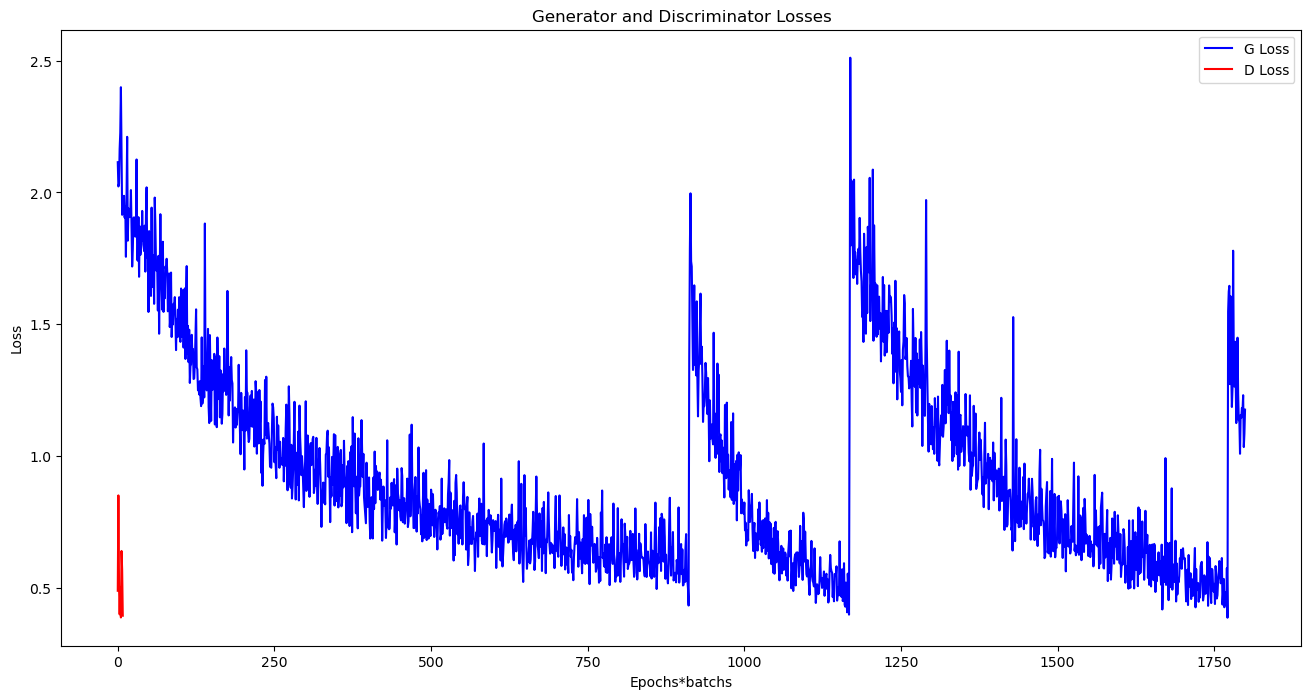

In [757]:
plt.figure(figsize=(16,8))

# Plot G_losses in blue
plt.plot(np.array(G_losses), 'b', label='G Loss')

# Plot D_losses in red
plt.plot(np.array(D_losses), 'r', label='D Loss')

plt.legend()

plt.xlabel('Epochs*batchs')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Losses')
plt.show()

In [758]:
final=[]
# Sample noise
z = torch.randn(32, z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
# generate images!
final += list(generator(z).data)
print(len(final))
for i in range(len(final)):
    save_image(final[i], f"result_images/{dirpath}/final%d.png" % i,normalize=True)


32


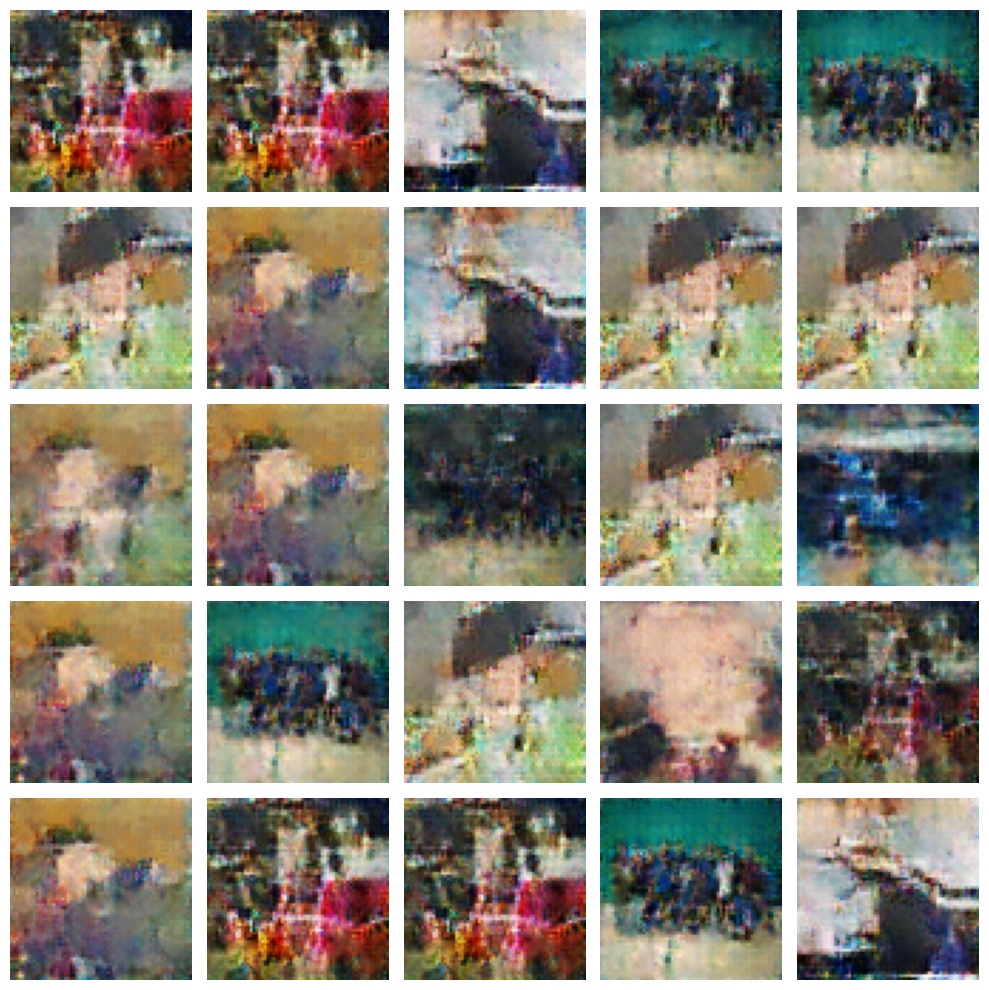

In [759]:
# 將其轉換為 PIL Image
# imgs_pil = [transforms.ToPILImage()(img.cpu().detach()) for img in gen_imgs.data[:]]

newgen = []
z_dim = 100  # 假设 z_dim 是 100
z = torch.randn(25, z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
# generate images!
newgen += list(generator(z).data)

# 假设生成器输出的图像范围在 [-1, 1] 之间，将其转换为 [0, 1]
newgen = [(img + 1) / 2 for img in newgen]

# Convert to PIL images
imgs_pil = [transforms.ToPILImage()(img.cpu().detach()) for img in newgen]

# Set the number of columns and rows for subplots
num_cols = 5
num_rows = 5

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Plot each image in the subplot
for i in range(num_rows):
    for j in range(num_cols):
        ax = axes[i, j]
        ax.axis('off')
        ax.imshow(imgs_pil[i * num_cols + j])

# Display images
plt.tight_layout()
plt.show()

In [760]:
# origin back up
# import numpy as np
# import math
# import os
# from tqdm import tqdm

# # import lib for img processing
# from torchvision.datasets import ImageFolder
# import torchvision.transforms as transforms
# from torchvision.utils import save_image

# # import lib for data processing
# from torch.utils.data import DataLoader
# from torchvision import datasets

# #　in this tutorial, i implement pytorch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch

# import matplotlib.pyplot as plt
# from torchvision.utils import make_grid
# n_epochs = 500  #epochs
# batch_size = 32   #batch size recommend that more than 32
# lr_rate = 0.0002   #learning rate
# beta1 = 0.5    #learning rate beta1
# beta2 = 0.999    #beta2
# tmp_size = 128   #image tmp crop size
# ext_size=200     #extend
# img_size = 64   #image size
# channels = 3    #RGB
# img_shape = (channels, img_size, img_size) # gray scale (channels,img_size,img_size)
# img_pixel = int(np.prod(img_shape)) # total pixel is 1*img_size*img_size
# z_dim = 100     #z_dim is latent_dim
# interval = 10  # How often to sample

# # dirpath='real_only'
# dirpath='anime_only'
# # dirpath='real+anime'
# # dirpath='real+anime+me'


# gpath = f"{dirpath}_generator.pth"
# dpath = f"{dirpath}_discriminator.pth"
# from PIL import Image
# import torchvision.transforms.functional as functional
# class CenterCropAndResize(object):
#     def __init__(self, output_size):
#         assert isinstance(output_size, (int, tuple))
#         self.output_size = output_size

#     def __call__(self, image):

#         width, height = image.size
#         short_side = min(width, height)

#         image= functional.center_crop(image, short_side)
#         image= functional.resize(image,self.output_size)

#         # Resize the image
#         # image = image.resize(new_size, Image.BILINEAR)

#         # # 將 tensor 轉換成 numpy array，並調整通道的位置
#         # image_np = np.transpose(image.numpy(), (1, 2, 0))
#         # # 顯示圖像
#         # plt.imshow(image)

#         # plt.show()
#         # print(image.size)
#         return image
# # 定義圖像轉換
# # transform = transforms.Compose([
# #     transforms.CenterCrop((tmp_size, tmp_size)),      # 切大小為 tmp_size*tmp_size
# #     transforms.Resize((img_size, img_size)),        # 縮放img_size*img_size
# #     transforms.ToTensor(),            # 轉換為 tensor
# #     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])  # 正規化圖像
# # ])
# transform = transforms.Compose([
#     # CenterCropAndResize(64),  # 中心裁剪到正方形，然後縮放到 720x720
#     transforms.Resize((ext_size, ext_size)),        # 縮放img_size*img_size
#     transforms.CenterCrop((tmp_size, tmp_size)),      # 切大小為 tmp_size*tmp_size
#     transforms.Resize((img_size, img_size)),        # 縮放img_size*img_size
#     transforms.ToTensor(),  # 轉換為 tensor
#     transforms.Normalize([0.5], [0.5])  # 正規化圖像
# ])

# # 創建 ImageFolder 數據集實例
# dataset = ImageFolder(root=f'data/{dirpath}', transform=transform)

# # 使用 DataLoader 加載數據集
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# # creat a Discriminator
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
    
#         self.FC = nn.Sequential(
#             nn.Linear(img_pixel, 512),  # img_pixel is 784
#             nn.LeakyReLU(0.2, inplace=True), # limit data to 0~1 to avoid Vanishing gradient problem
#             nn.Linear(512, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 128),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(128, 1),
#             nn.Sigmoid(),         # before classify, use sigmoid.
#         )
    
#     def forward(self, img):
#         flat = img.view(img.size(0), -1)
#         validity = self.FC(flat)
    
#         return validity
# # create a generator
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
    
    
#         self.FCin = nn.Linear(z_dim, 128)
#         self.FC1 = self._block(128, 256)
#         self.FC2 = self._block(256, 512)
#         self.FC3 = self._block(512, 1024)
#         self.FCout = nn.Sequential(
#             nn.Linear(1024, img_pixel),
#             nn.Tanh(),
#         )
    
    
#       # hidden layer
#     def _block(self, in_fea, out_fea):
#         return nn.Sequential(
#             nn.Linear(in_fea, out_fea),
#             nn.BatchNorm1d(out_fea, 0.8),  # google it
#             nn.LeakyReLU(0.2, inplace=True),
#         )
    
#       # put random z into layer sequentially.
#     def forward(self, z):
#         flat = z.view(z.size(0), -1)
#         fea = self.FCin(flat)
#         fea = self.FC1(fea)
#         fea = self.FC2(fea)
#         fea = self.FC3(fea)
#         fake_img = self.FCout(fea)
#         fake_img = fake_img.view(fake_img.size(0), *img_shape)
#         return fake_img
# adversarial_loss = torch.nn.BCELoss()
# # at first we need to get our gpu!
# if torch.cuda.is_available():
#     device =torch.device("cuda:0")
# else:
#     device =torch.device('cpu')

# # call the generator and discriminator
# generator = Generator()
# discriminator = Discriminator()



# # put them into your device
# if torch.cuda.is_available():
#     generator = generator.to(device)
#     discriminator = discriminator.to(device)

# # Create Optimizer
# # In this tutorial we use Adam
# optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_rate, betas=(beta1, beta2))
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_rate, betas=(beta1, beta2))

# # create a folder to save image
# os.makedirs("./result_images", exist_ok = True)
# # ------------------
# # Training Start
# # ------------------
# G_losses=[]
# D_losses=[]


# # # 檢查路徑是否存在
# if os.path.exists(gpath):
#     generator.load_state_dict(torch.load(gpath))
# if os.path.exists(dpath):
#     discriminator.load_state_dict(torch.load(dpath))
# print("FINISHING LOADING PTH")


# for epoch in range(n_epochs):
#     for batch_id, (img, _) in enumerate(tqdm(dataloader)):
#         # throw our img into gpu
#         real_imgs = img.to(device)
    
#         # create label to caculate BCE
#         _valid = torch.ones(size=(real_imgs.shape[0], 1), requires_grad=False).to(device) # (batch_size, 1) [1, 1, 1,...]
#         _fake = torch.zeros(size=(real_imgs.shape[0], 1), requires_grad=False).to(device) # (batch_size, 0) [0, 0, 0,...]
    
    
#         # -----------------
#         # Train Generator
#         # -----------------
#         # Reset 
#         optimizer_G.zero_grad()
#         # Sample noise
#         z = torch.randn(real_imgs.shape[0], z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
#         # generate images!
#         gen_imgs = generator(z)

#         # Generator :min log(1 - D(G(z))) <-> max log(D(G(z))
#         g_loss = adversarial_loss(discriminator(gen_imgs), _valid)
    
#         g_loss.backward()
#         optimizer_G.step()
#         G_losses.append(g_loss.item())
        
        
#         # --------------------
#         # Train Discriminator
#         # --------------------
#         optimizer_D.zero_grad()
    
#         # Discriminator: max log(D(x)) + log(1 - D(G(z)))
#         real_loss = adversarial_loss(discriminator(real_imgs), _valid)
#         fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), _fake)
#         d_loss = (real_loss + fake_loss) / 2
    
#         d_loss.backward()
#         optimizer_D.step()
    
#         D_losses.append(d_loss.item())
#         print(
#           "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
#           % (epoch, n_epochs, batch_id, len(dataloader), d_loss.item(), g_loss.item())
#         )
    
#         batches_done = epoch * len(dataloader) + batch_id
#         if batches_done % interval == 0:
#             save_image(gen_imgs.data[:25], "result_images/%d.png" % batches_done, nrow=5, normalize=True)
#             print(f"FULLTOGO:{len(gen_imgs)}")

            
# # save
# print("SAVING PTH")
# torch.save(generator.state_dict(), gpath)
# torch.save(discriminator.state_dict(), dpath)      
# plt.figure(figsize=(12,8))

# # Plot G_losses in blue
# plt.plot(np.array(G_losses), 'b', label='G Loss')

# # Plot D_losses in red
# plt.plot(np.array(D_losses), 'r', label='D Loss')

# plt.legend()
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Generator and Discriminator Losses')
# plt.show()
# final=[]
# # Sample noise
# z = torch.randn(64, z_dim, 1, 1).to(device)  # (batch_size, z_dim, 1, 1)
# # generate images!
# final += list(generator(z).data)
# print(len(final))
# for i in range(len(final)):
#     save_image(final[i], "result_images/final%d.png" % i,normalize=True)
# # 將其轉換為 PIL Image
# imgs_pil = [transforms.ToPILImage()(img.cpu().detach()) for img in gen_imgs.data[:]]

# print(len(gen_imgs))
# print(len(imgs_pil))
# print(len(gen_imgs.data))
# # # 設置子圖的列數和行數
# num_rows =2
# num_cols =2

# # # 創建子圖
# fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# # # 用 PIL Image 在子圖上繪製圖像
# for i in range(num_rows):
#     for j in range(num_cols):
#         ax = axes[i, j]
#         ax.axis('off')
#         ax.imshow(imgs_pil[i * num_cols + j])

# # # 顯示圖像
# plt.tight_layout()
# plt.show()